In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['font.family'] = 'Calibri'

import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu

import matplotlib.patches as mpatches
from scipy.stats import wilcoxon
from scipy.stats import pearsonr

from scipy import stats
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.expand_frame_repr', True)
import warnings
warnings.filterwarnings('ignore')

path = '/home/ripper8/projects/working_data/GRNv3knockouts/analysis'
experiments = ['reg10m2', 'reg2m2']
exp_labels = ['R10','R2']


In [22]:
traits = ['disp_y', 'distance', 'extremities_prop', 'symmetry', 'proportion', 
          'coverage', 'extensiveness_prop', 'branching_prop','modules_count','hinge_prop']

traits_labels = ['fitness', 'growth', 'limbs', 'symmetry', 'proportion', 
              'coverage', 'limbs length', 'branching','size','joints']

df_traits = {}
df_categ_traits = {}

for trait in traits:
    print('>>>>>',trait)
    df_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effects_{trait}.csv')
    df_traits[trait]['epistasis_percent'] = df_traits[trait]['positive'] + df_traits[trait]['negative']
    df_traits[trait]['avg_negative']  = df_traits[trait]['avg_negative'] * -1

    df_categ_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effectscateg_{trait}.csv')

   
   

>>>>> disp_y
>>>>> distance
>>>>> extremities_prop
>>>>> symmetry
>>>>> proportion
>>>>> coverage
>>>>> extensiveness_prop
>>>>> branching_prop
>>>>> modules_count
>>>>> hinge_prop


In [23]:

keys = ['experiment_name', 'run', 'gen', 'individual_id']

df_complexity = pd.read_csv(f'{path}/complexity/complexity.csv').drop(columns=['geno_size'])
df_complexity_net = pd.read_csv(f'{path}/complexity/complexity_net.csv')
df_complexity_all = pd.merge(df_complexity, df_complexity_net, on=keys, how='inner')

df_complexity_all['interactions_density'] = df_complexity_all['complexity_net'] / df_complexity_all['n_genes']


>>>>> disp_y
>> 0


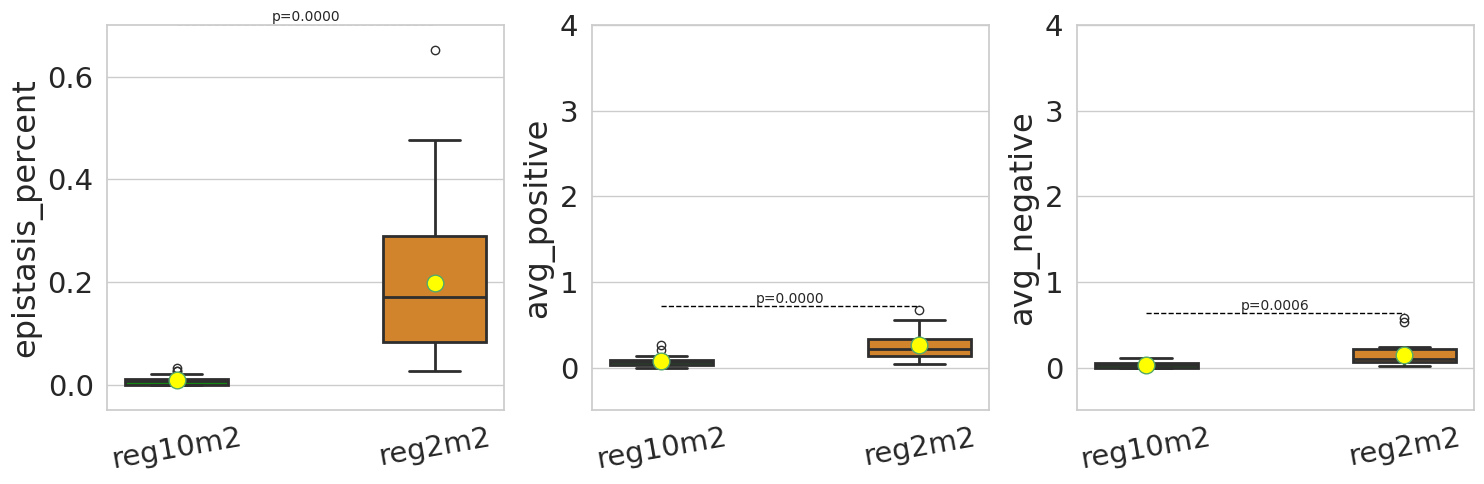

>> 100


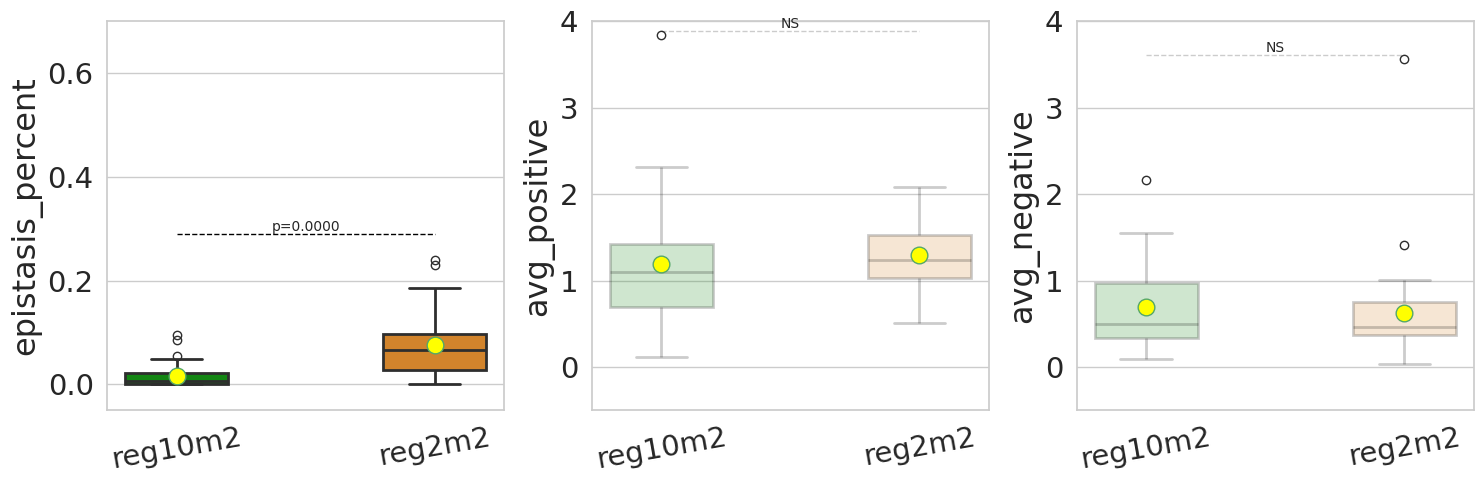

>>>>> distance
>> 0


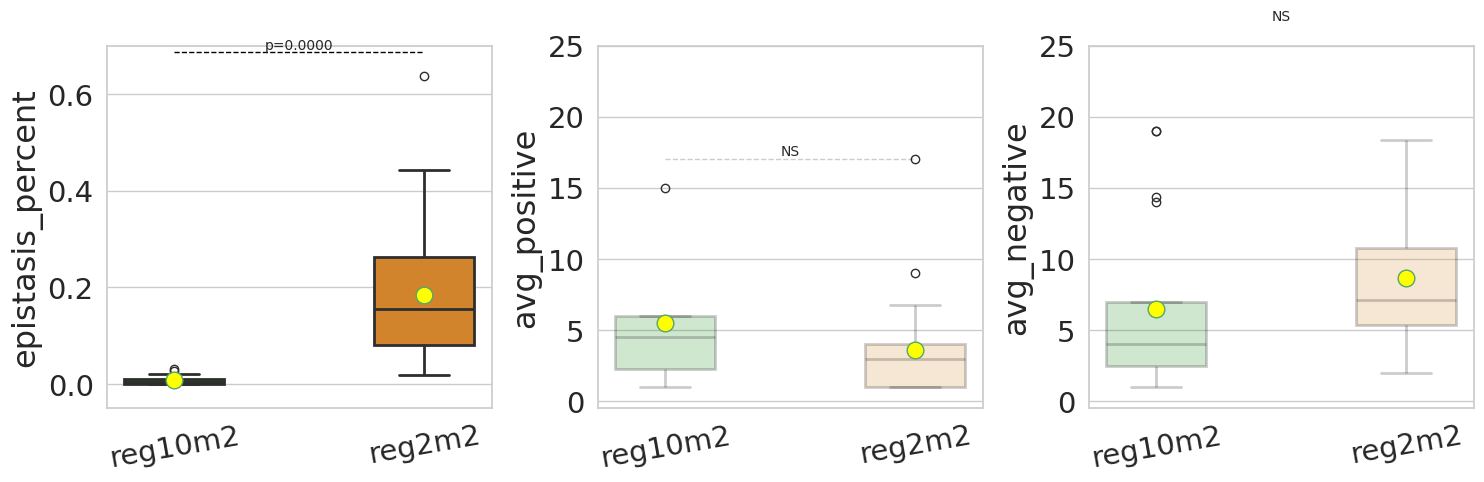

>> 100


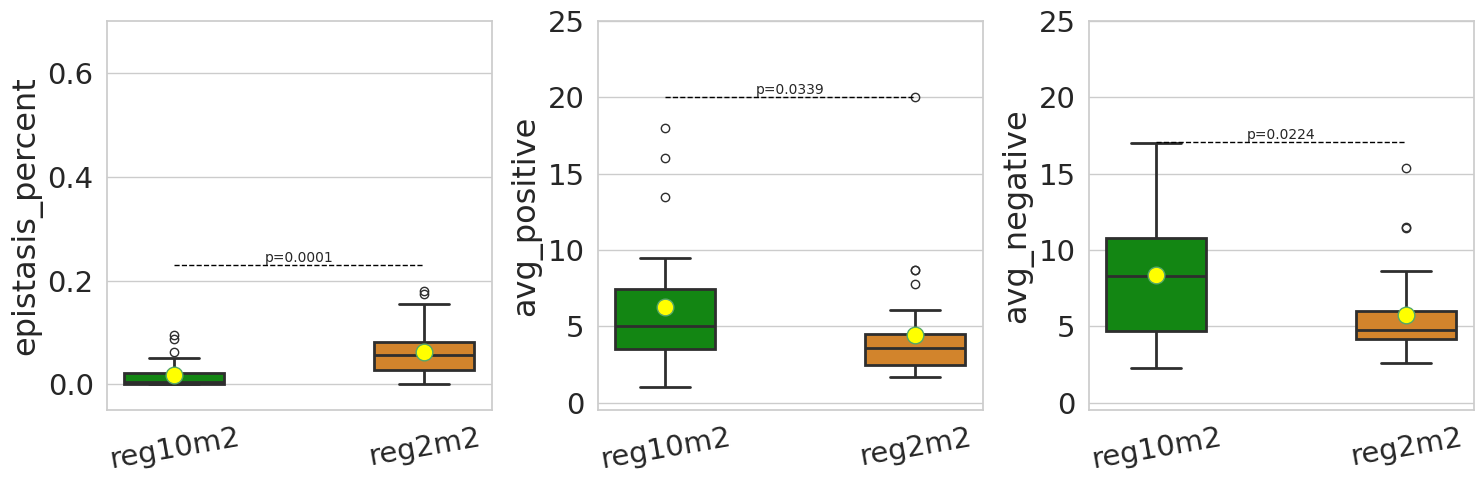

>>>>> extremities_prop
>> 0


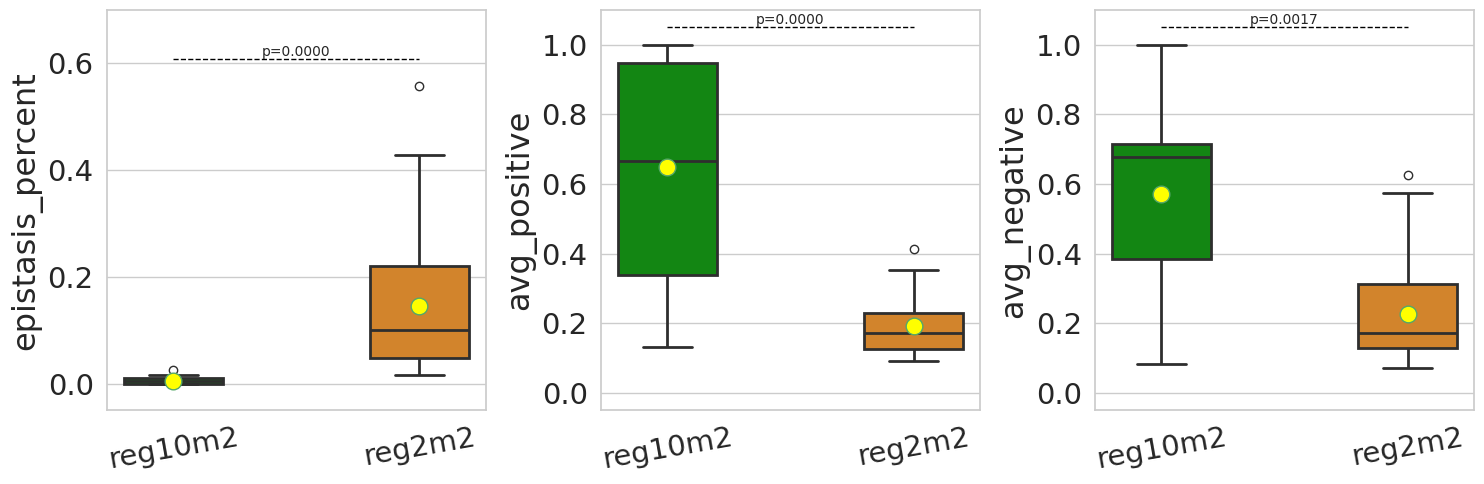

>> 100


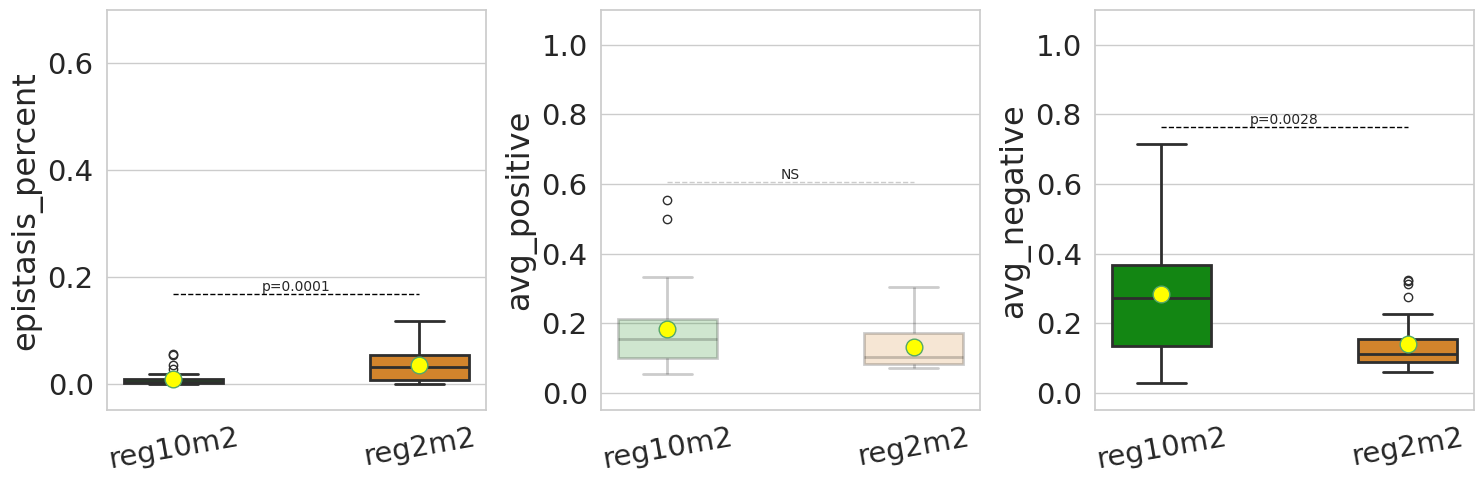

>>>>> symmetry
>> 0


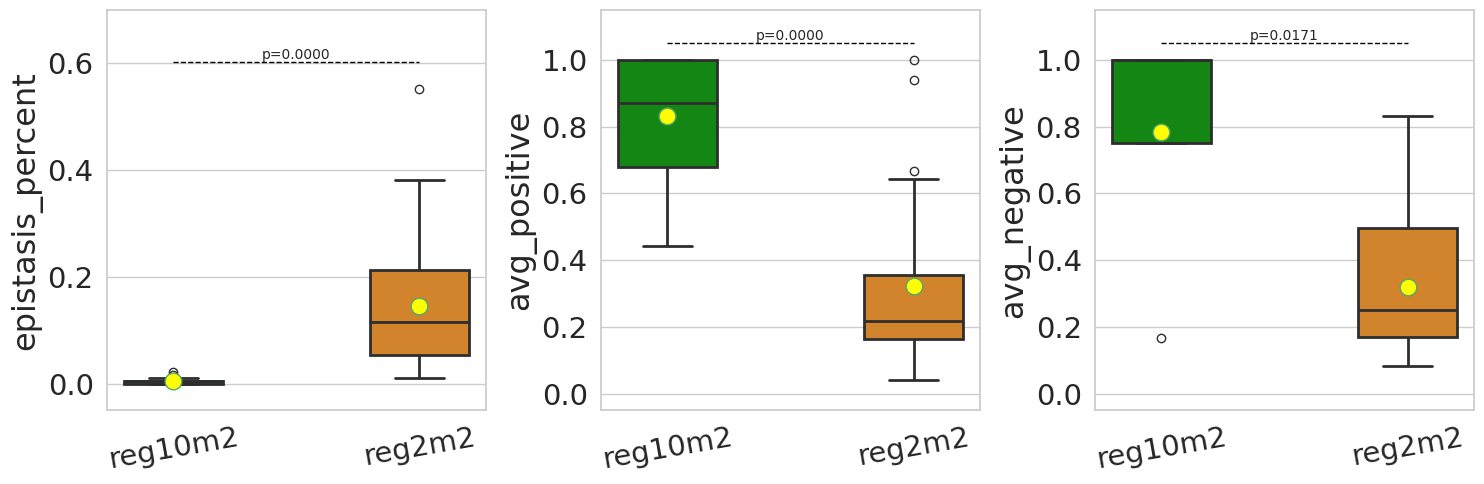

>> 100


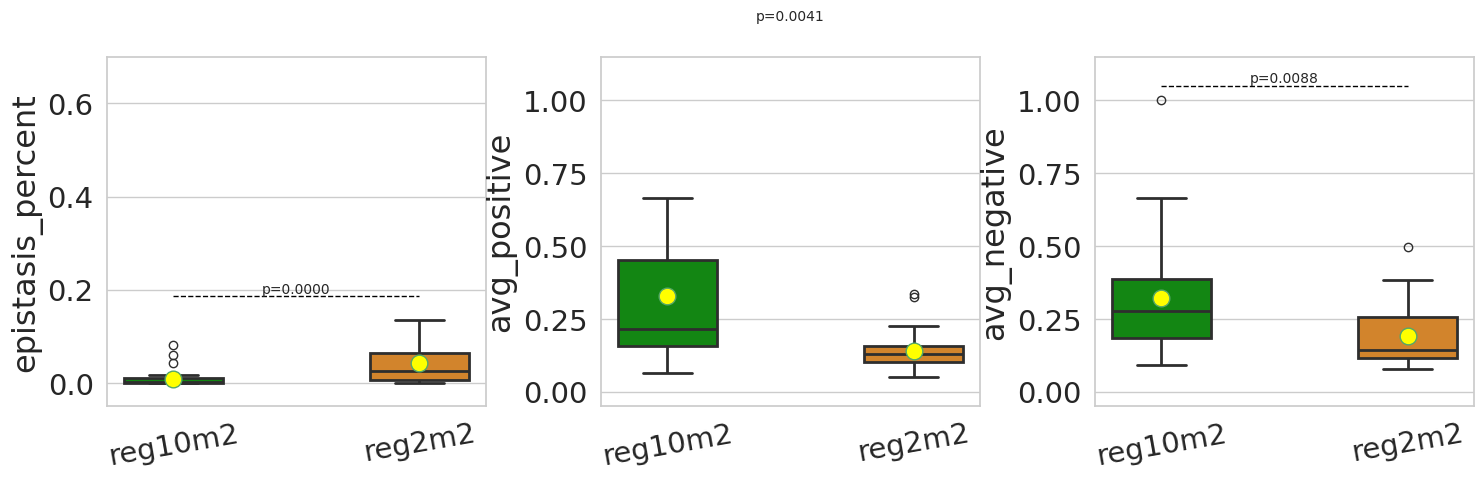

>>>>> proportion
>> 0


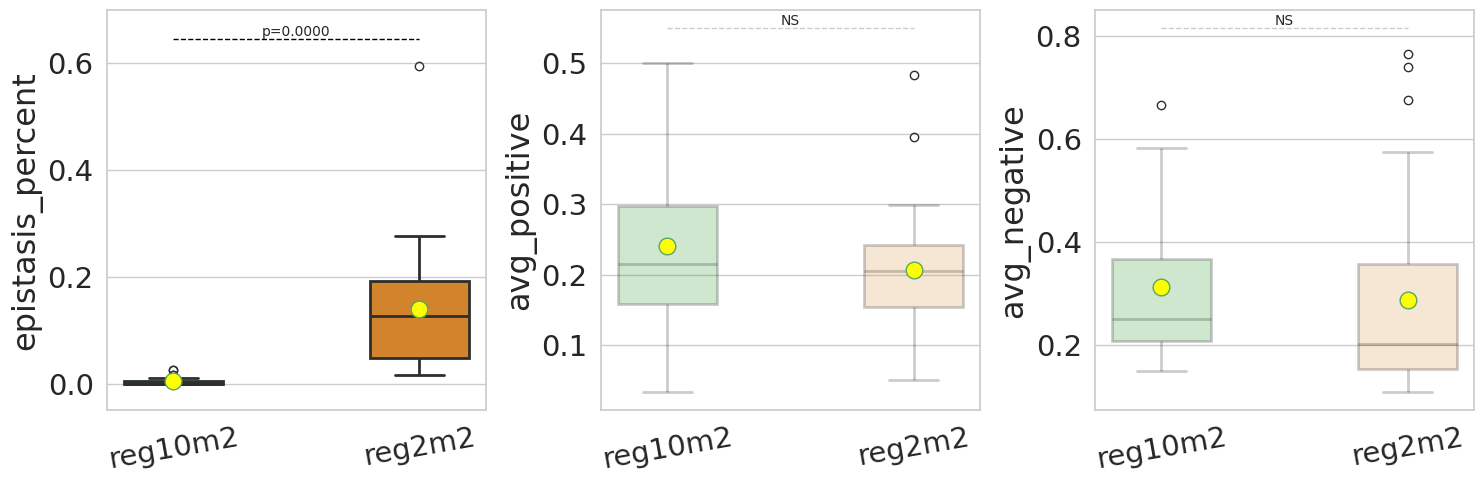

>> 100


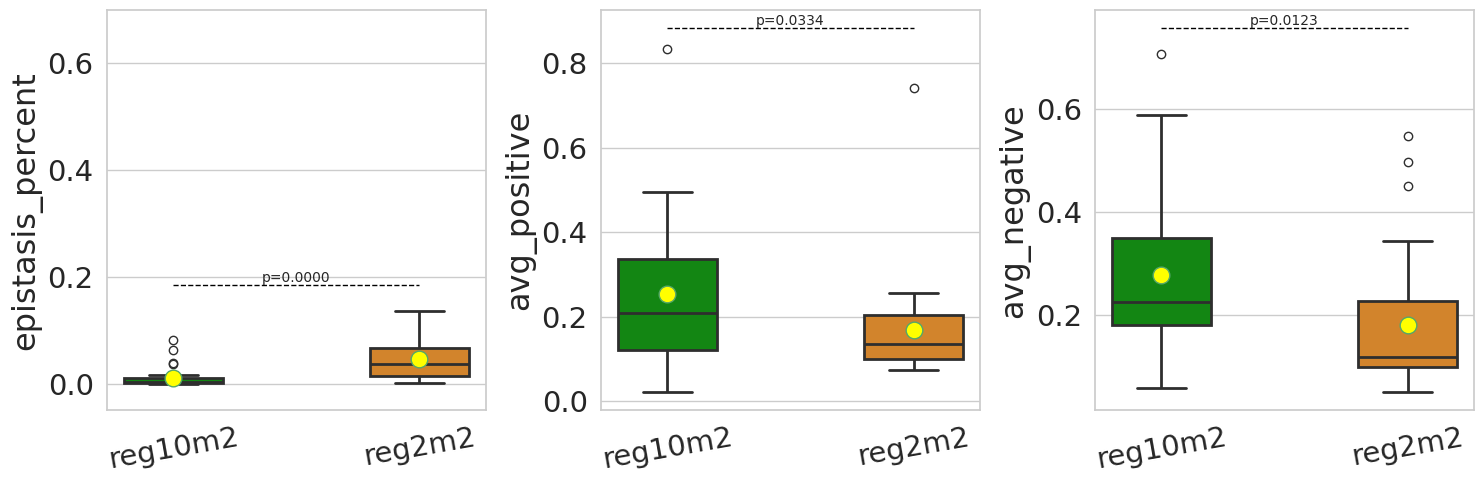

>>>>> coverage
>> 0


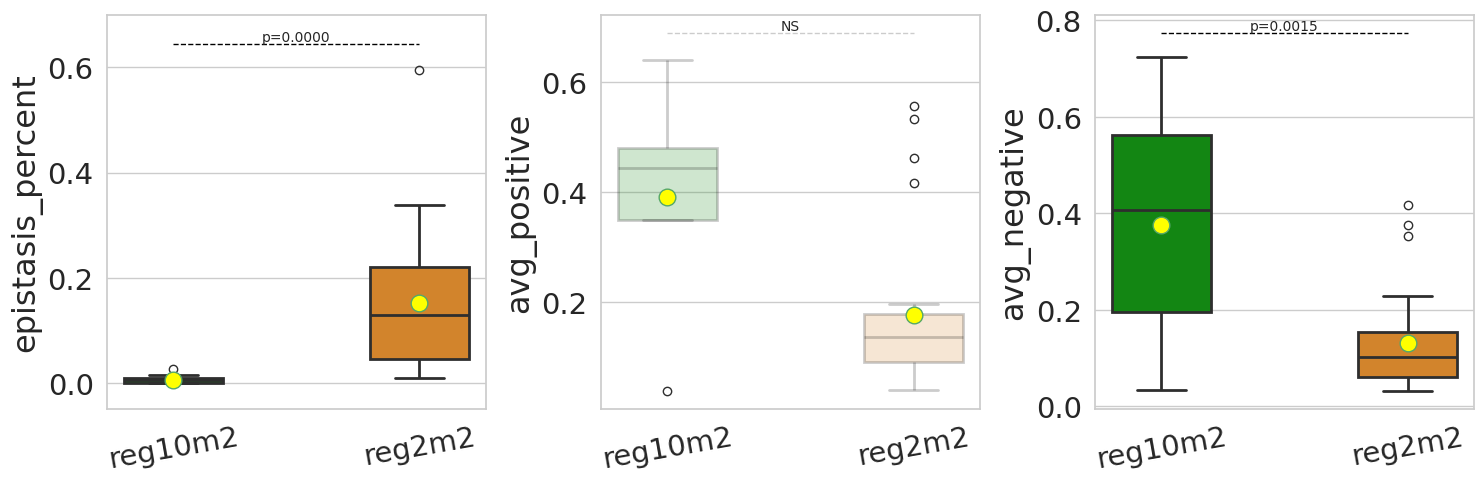

>> 100


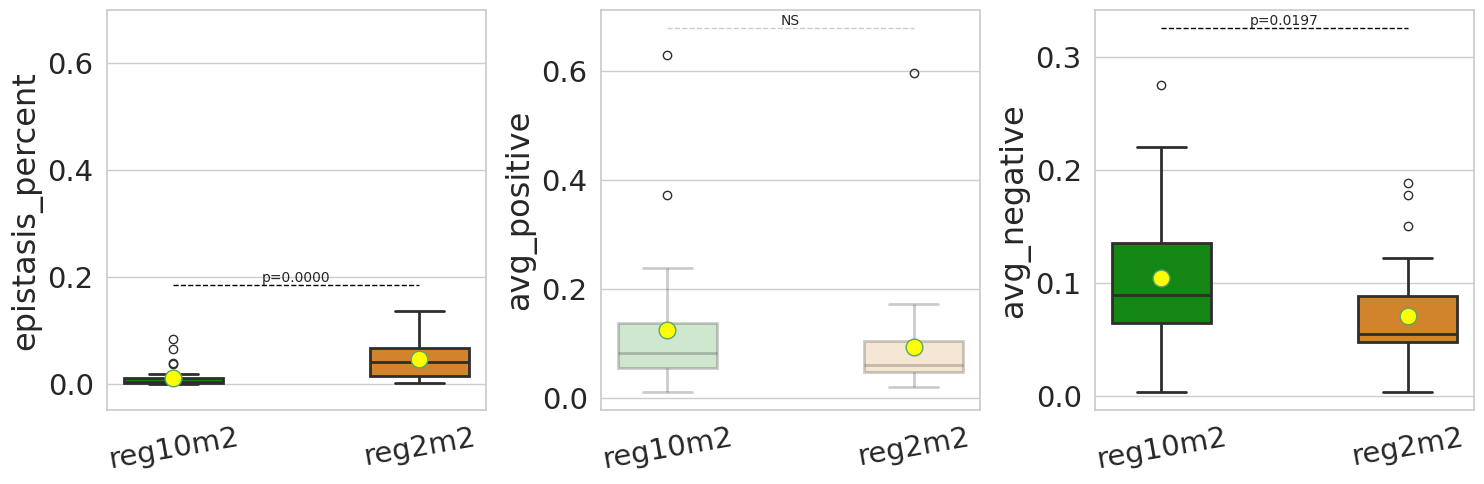

>>>>> extensiveness_prop
>> 0


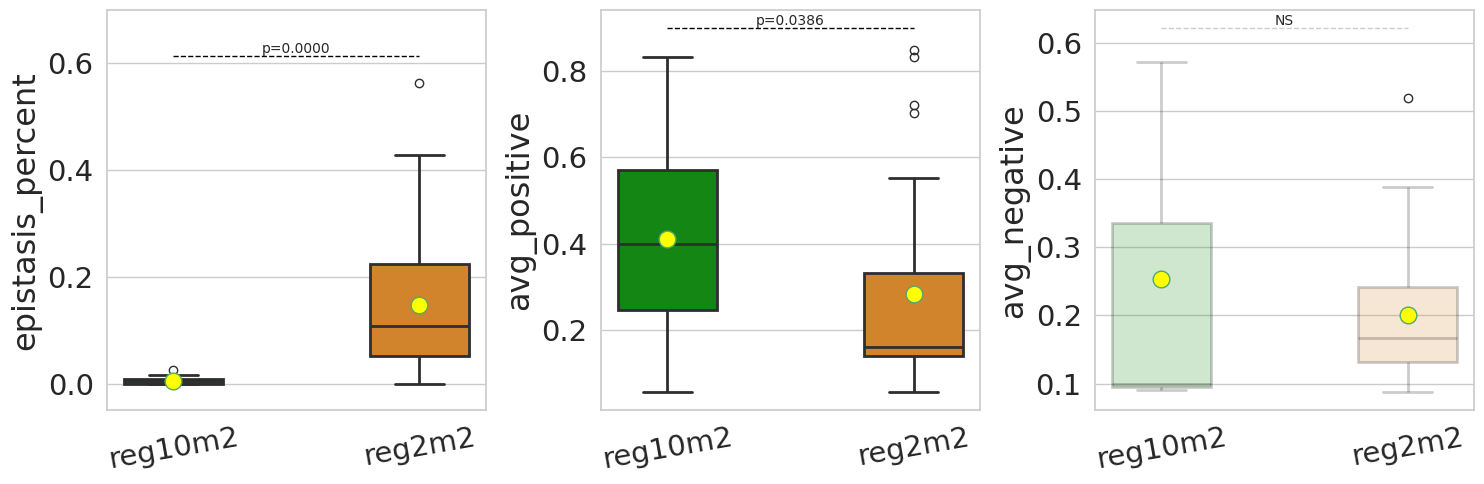

>> 100


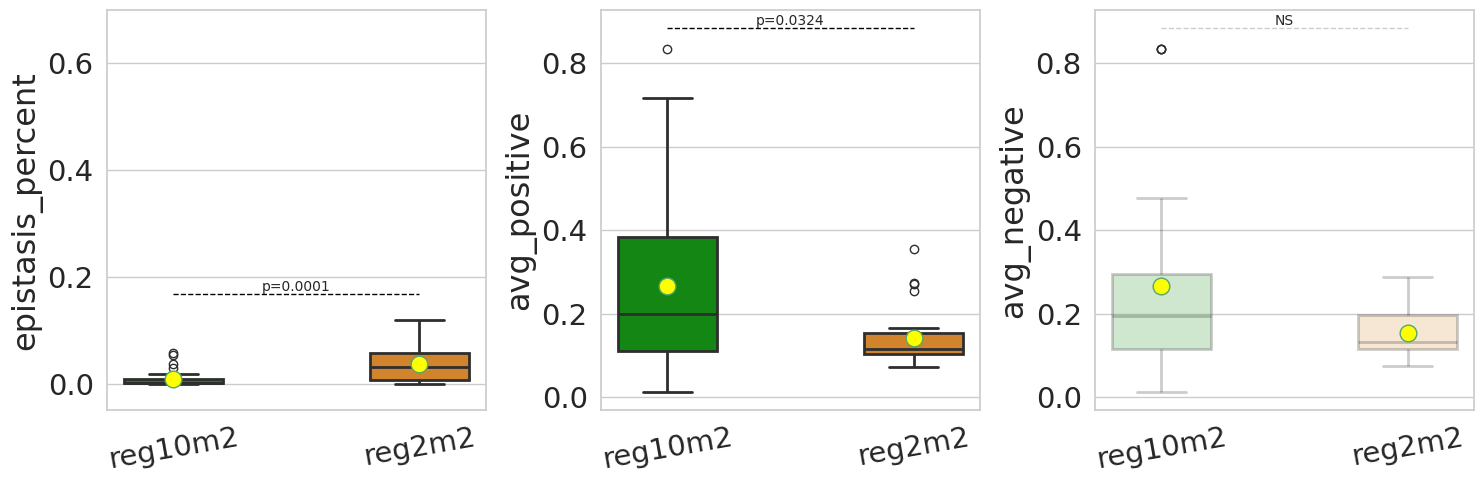

>>>>> branching_prop
>> 0


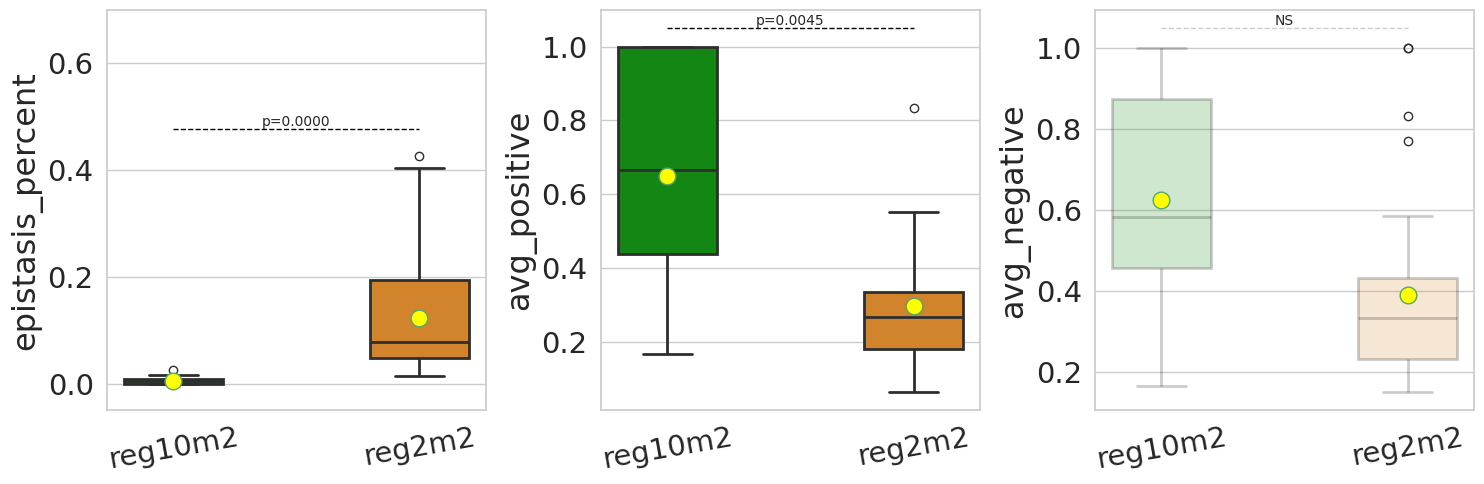

>> 100


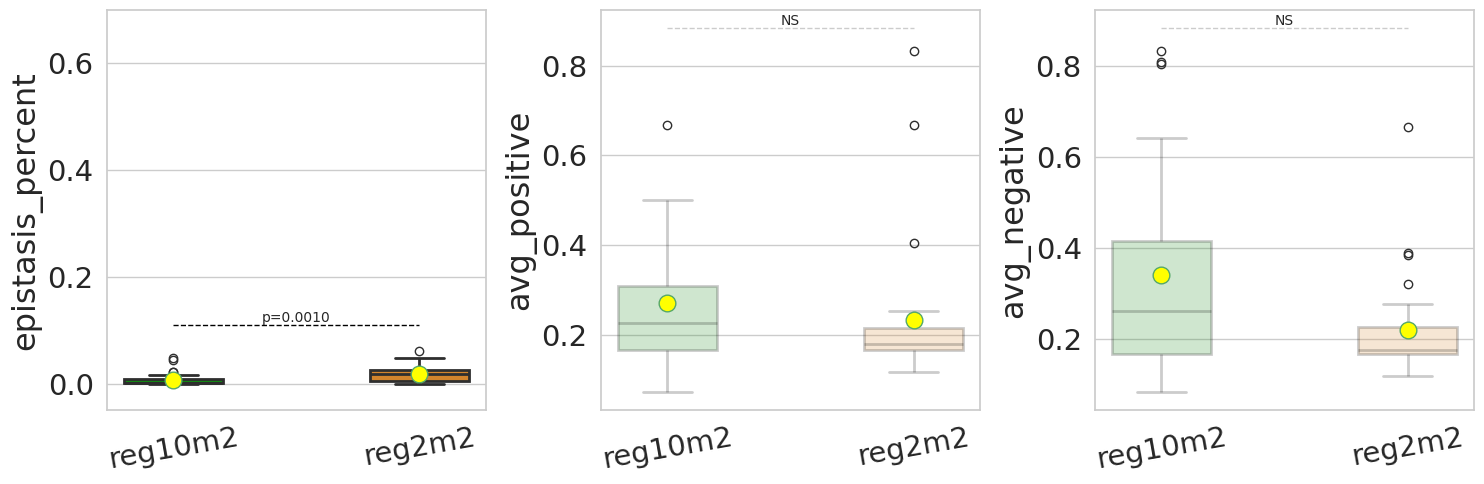

>>>>> modules_count
>> 0


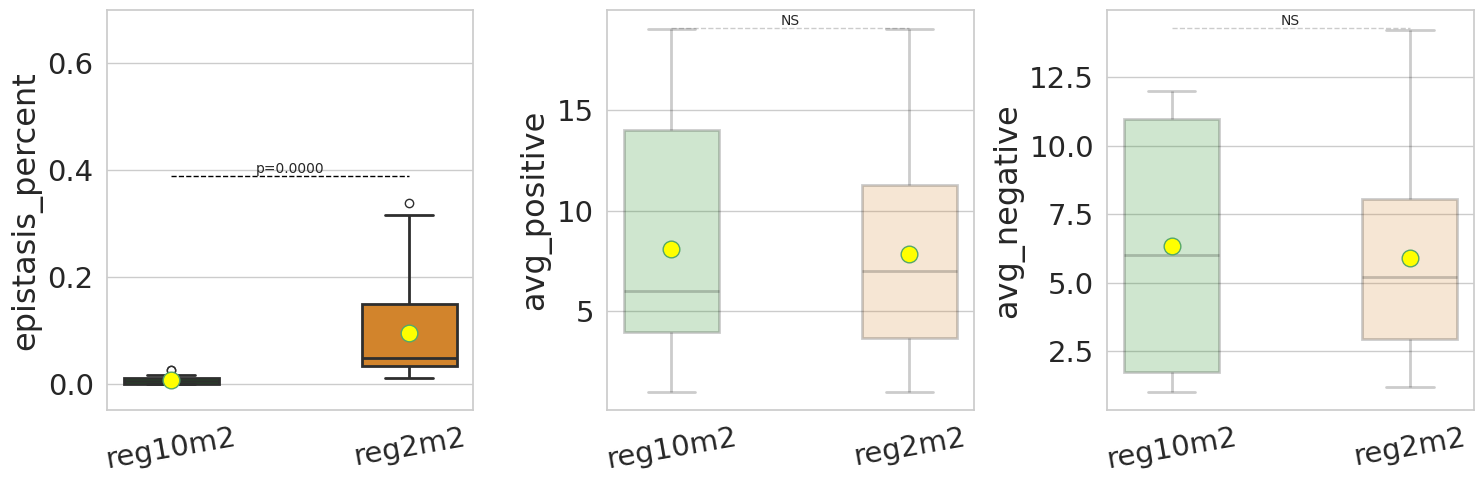

>> 100


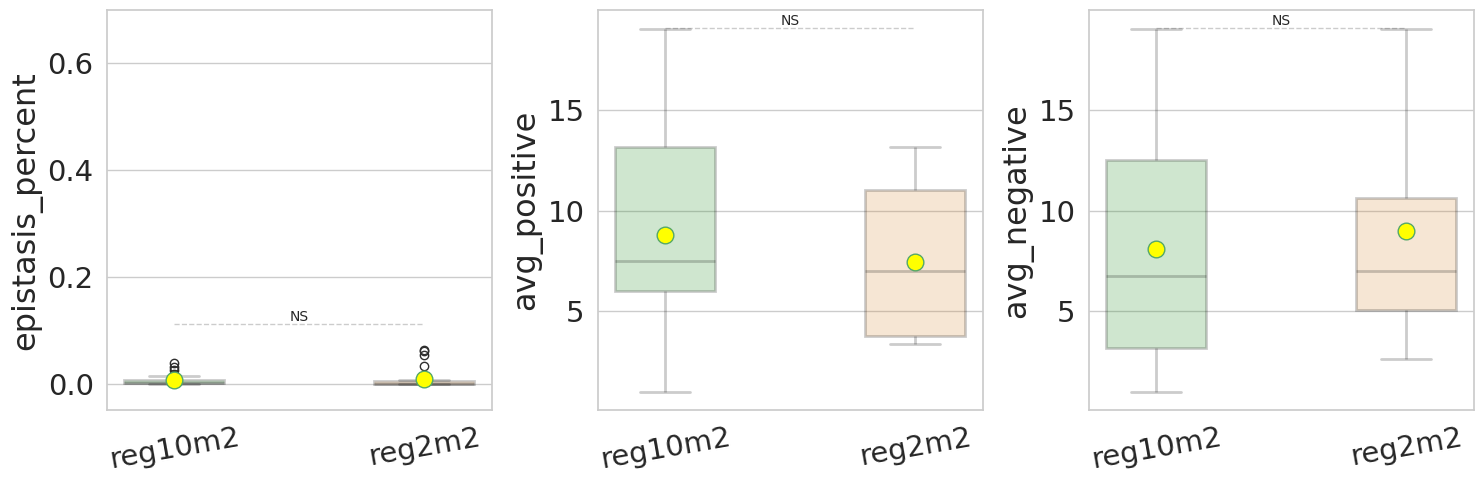

>>>>> hinge_prop
>> 0


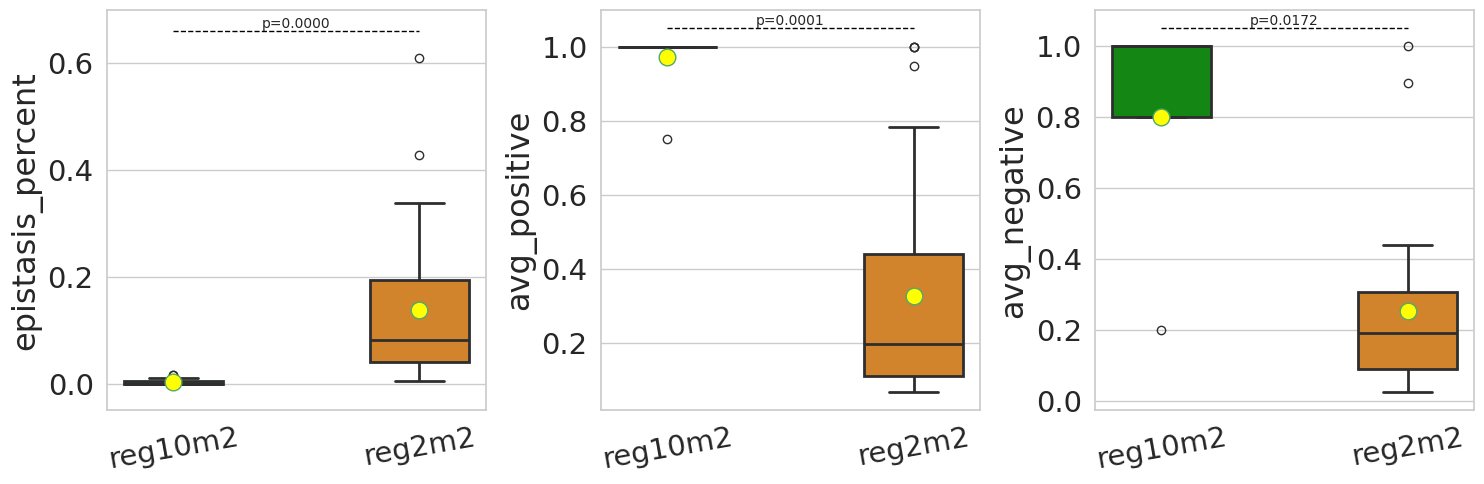

>> 100


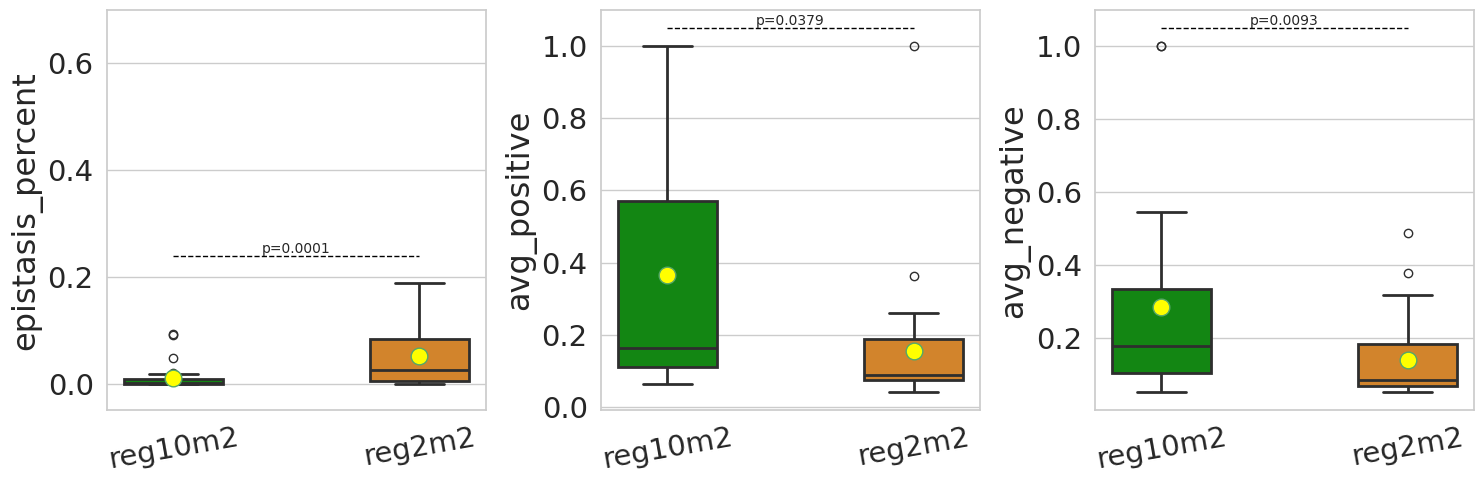

In [24]:
### EPISTASIS CHANGES r10/r2: raw data ###

metrics = ['epistasis_percent',  'avg_positive',  'avg_negative']
metric_labels = ['epistasis %','strength +', 'strength $-$']
#epistasis strenght (+)
clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_traits[trait].copy(deep=True)
    
    for gen in [0, 100]:
        print('>>',gen)
        df_trait_exp = df_trait[df_trait['gen'] == gen]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['experiment_name'] == 'reg10m2'][f'{metric}']
            end_gen = filtered_clean[filtered_clean['experiment_name'] == 'reg2m2'][f'{metric}']
     
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
           # print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='experiment_name', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)

            y_max = filtered_clean[f'{metric}'].max() + 0.05  #
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
            
            if metric in ['epistasis_percent']:
                ax.set_ylim(-0.05, 0.7)

            if metric == 'avg_positive' or metric == 'avg_negative':
                if trait in avg_pos_scale.keys():
                    ax.set_ylim(avg_pos_scale[trait][0], avg_pos_scale[trait][1])
      
            ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')
       
        plt.tight_layout()
        plt.show()







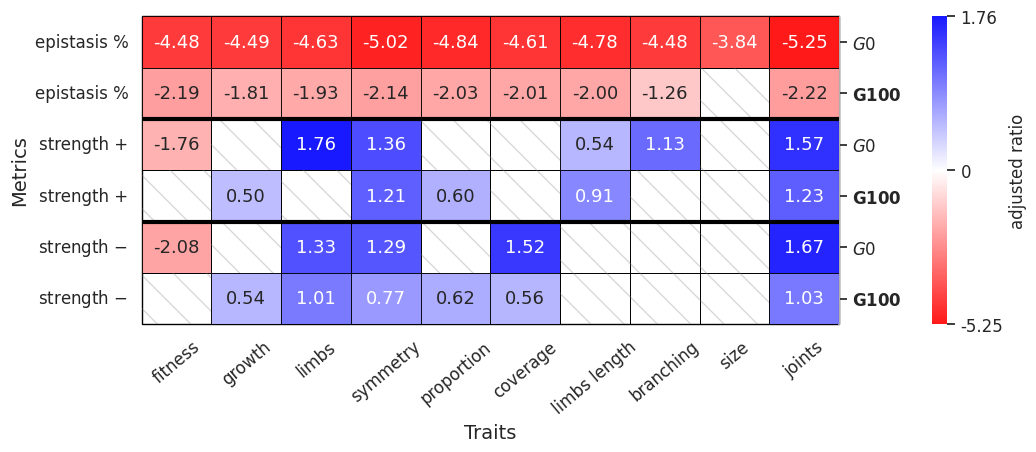

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.patches as patches

# Define traits and metrics
generations = [0, 100]

# Store ratio values for each metric, trait, and generation
heatmap_data = np.zeros((len(metrics) * len(generations), len(traits)))
heatmap_p = np.zeros((len(metrics) * len(generations), len(traits)))
annot_data = np.empty((len(metrics) * len(generations), len(traits)), dtype=object)

row_labels = []
gen_labels = []

for i, metric in enumerate(metrics):
    for gen_idx, gen in enumerate(generations):
        row_index = i * len(generations) + gen_idx
        row_labels.append(f"{metric}")
        if gen == 100:
            gen_labels.append(rf'$\mathbf{{G{gen}}}$')
        else:
            gen_labels.append(rf'$\mathit{{G{gen}}}$')
            
        for j, trait in enumerate(traits):
            df_trait = df_traits[trait].copy(deep=True)
            df_trait_exp = df_trait[df_trait['gen'] == gen]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            exp1 = filtered_clean[filtered_clean['experiment_name'] == 'reg2m2'][metric]
            exp2 = filtered_clean[filtered_clean['experiment_name'] == 'reg10m2'][metric]

            # Calculate averages and ratio
            avg_exp1 = exp1.mean()
            avg_exp2 = exp2.mean()
          #  perc = ((avg_exp2 / avg_exp1)-1) * 100
            transf_ratio = round(np.log2(avg_exp2 / avg_exp1),2)

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(exp1, exp2, alternative='two-sided')
            
            # Store in heatmap data
            heatmap_data[row_index, j] = transf_ratio
            heatmap_p[row_index, j] = p_value
          #  annot_data[row_index, j] = f"{transf_ratio:.0f}%"
            annot_data[row_index, j] = f"{transf_ratio:.02f}"

# Ensure finite values
heatmap_data = np.nan_to_num(heatmap_data, nan=0, posinf=np.nanmax(heatmap_data[np.isfinite(heatmap_data)]), neginf=np.nanmin(heatmap_data[np.isfinite(heatmap_data)]))

# Determine dynamic min and max values for normalization
vmin = np.min(heatmap_data)
vmax = np.max(heatmap_data)

# Create a colormap transitioning from red (negative values) to white (zero) to green (positive values)
cmap = LinearSegmentedColormap.from_list(
    "red_white_blue", ["red", "#ffffff", "blue"]
)

# Normalize the colormap with zero as the midpoint
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Create mask for non-significant values
mask_pvalue = heatmap_p > 0.05

fig, ax = plt.subplots(figsize=(12, 4))

# Plot the consolidated heatmap
sns.heatmap(
    heatmap_data, annot=annot_data, fmt="",
    cmap=cmap, linewidths=0.5, linecolor='black',
    alpha=0.9, annot_kws={'size': 13},
    xticklabels=traits, yticklabels=row_labels,
    ax=ax, mask=mask_pvalue, norm=norm,
   # cbar_kws={'label': r'Percentage difference ', 'pad': 0.1}
    cbar_kws={'label': r'adjusted ratio', 'pad': 0.1}
)

# Overlay crosshatching for non-significant p-values (p > 0.05)
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        if mask_pvalue[i, j]:
            rect = patches.Rectangle(
                (j, i), 1, 1, linewidth=0, edgecolor='grey',
                facecolor='none', hatch='\\' , alpha=0.3
            )
            ax.add_patch(rect)

# Remove grid lines
ax.set_xticks(ax.get_xticks(), minor=True)
ax.grid(False)

# Set x tick labels
ax.set_xticklabels(traits_labels, rotation=40, fontsize=12)

# Adjust y-axis labels
ax.set_yticklabels(np.repeat(metric_labels, 2), rotation=0, ha='right', fontsize=12)
ax2 = ax.secondary_yaxis('right')
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(gen_labels, rotation=0, ha='left', fontsize=12)

# Adjust color bar tick and label sizes
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(12)

# Ensure thick separating lines every two rows
for y in range(2, heatmap_data.shape[0], 2):
    ax.axhline(y=y, color='black', linewidth=3)

# Ensure bottom margin border is present
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

# 
#Set the ticks and labels for the colorbar
#colorbar_ticks = [-97,0,238]
colorbar_ticks = [vmin, 0 , vmax]
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels([f"{tick}" for tick in colorbar_ticks])
#cbar.set_ticklabels([f"int({tick})%" for tick in colorbar_ticks])

plt.xlabel("Traits",fontsize=14)
plt.ylabel("Metrics",fontsize=14)

# Save figure
fig.savefig(f'{path}/knockouts/epistasis_change_R10R2.png', dpi=300, bbox_inches='tight')


>>>>> disp_y
>> reg10m2


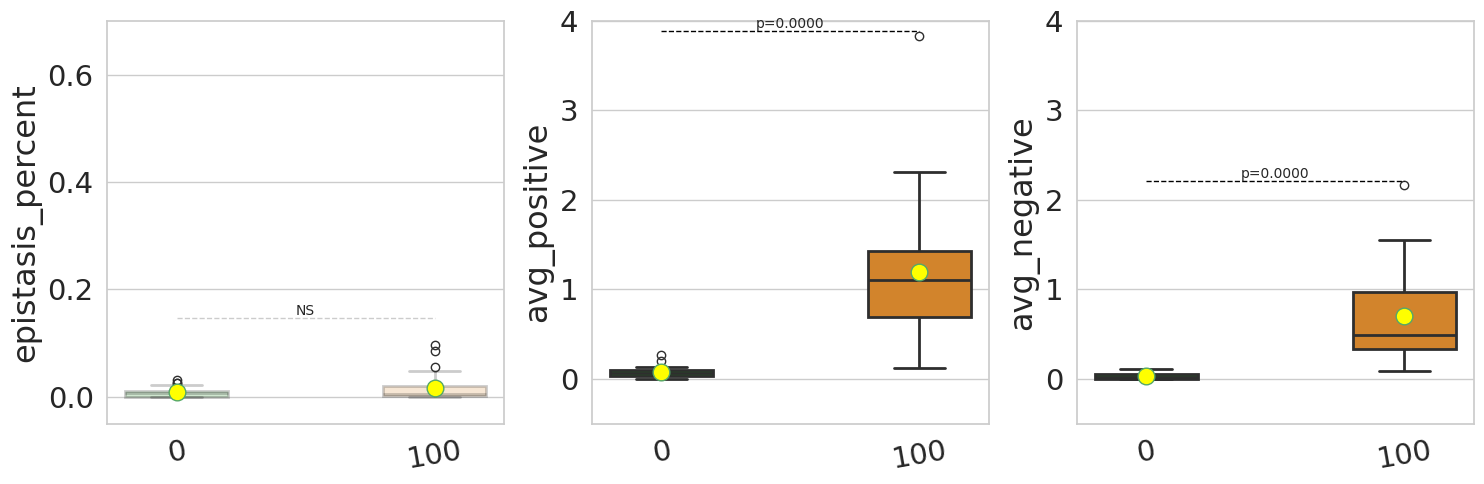

>> reg2m2


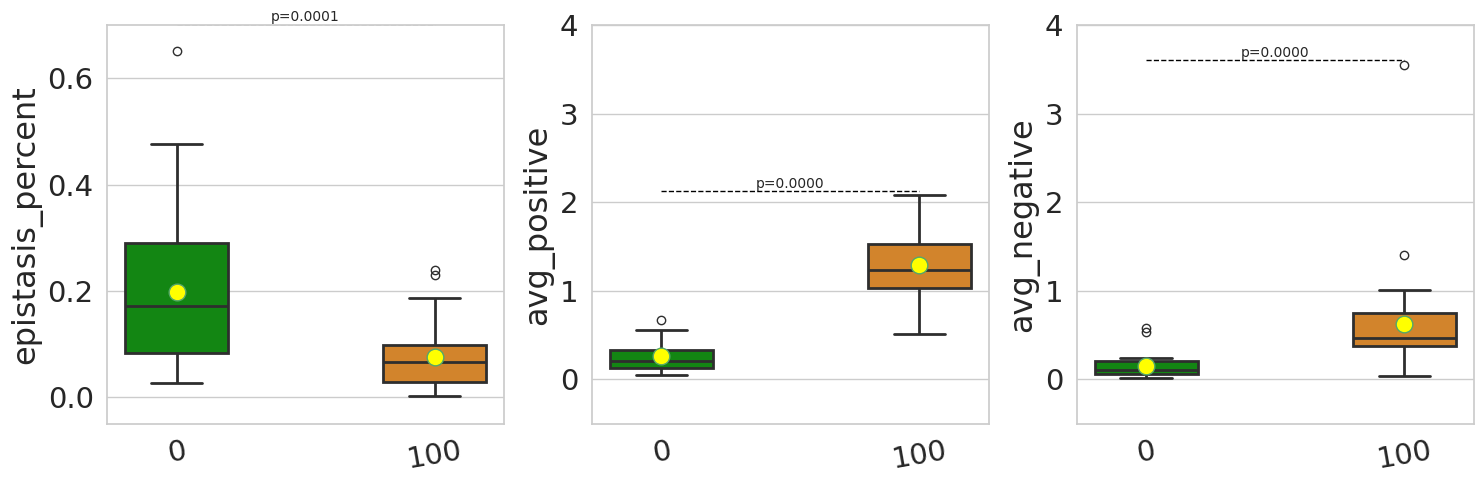

>>>>> distance
>> reg10m2


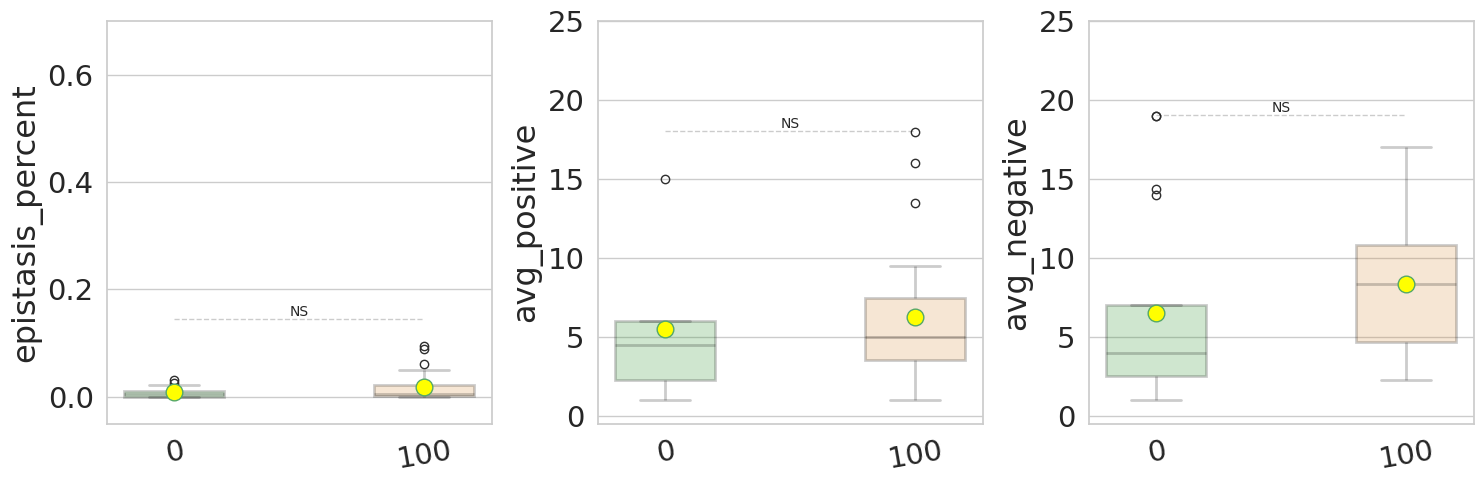

>> reg2m2


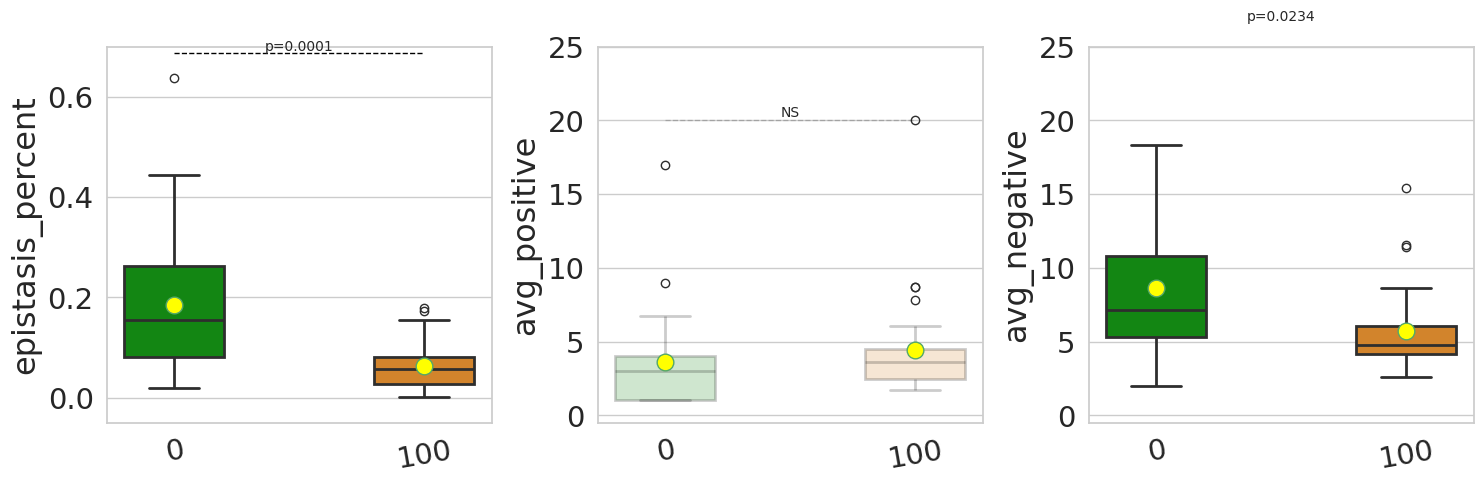

>>>>> extremities_prop
>> reg10m2


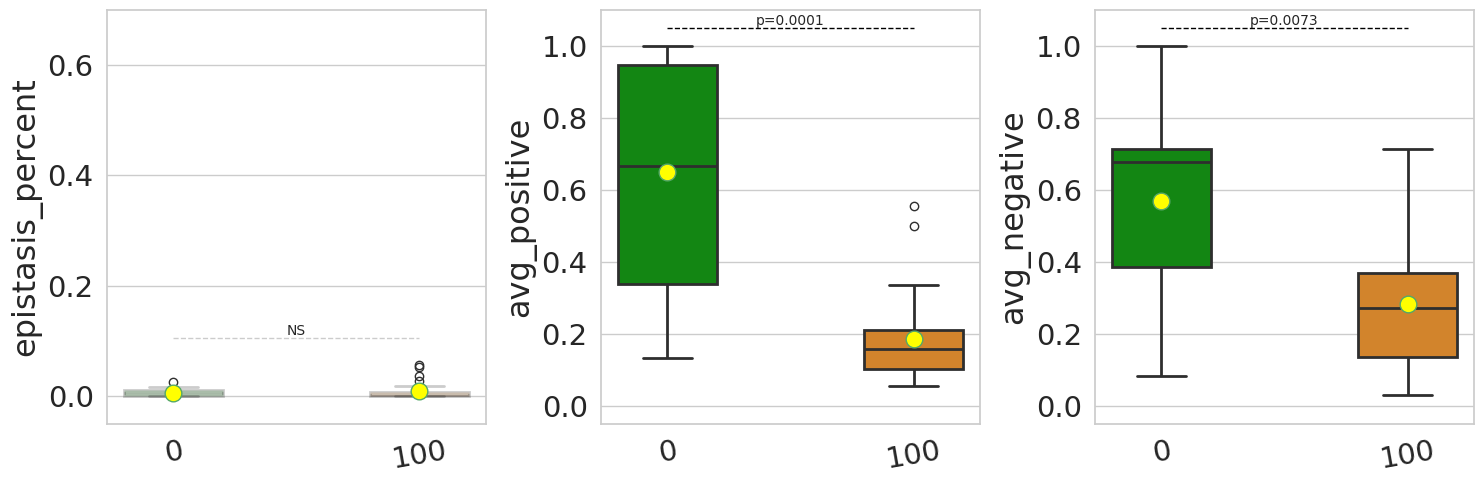

>> reg2m2


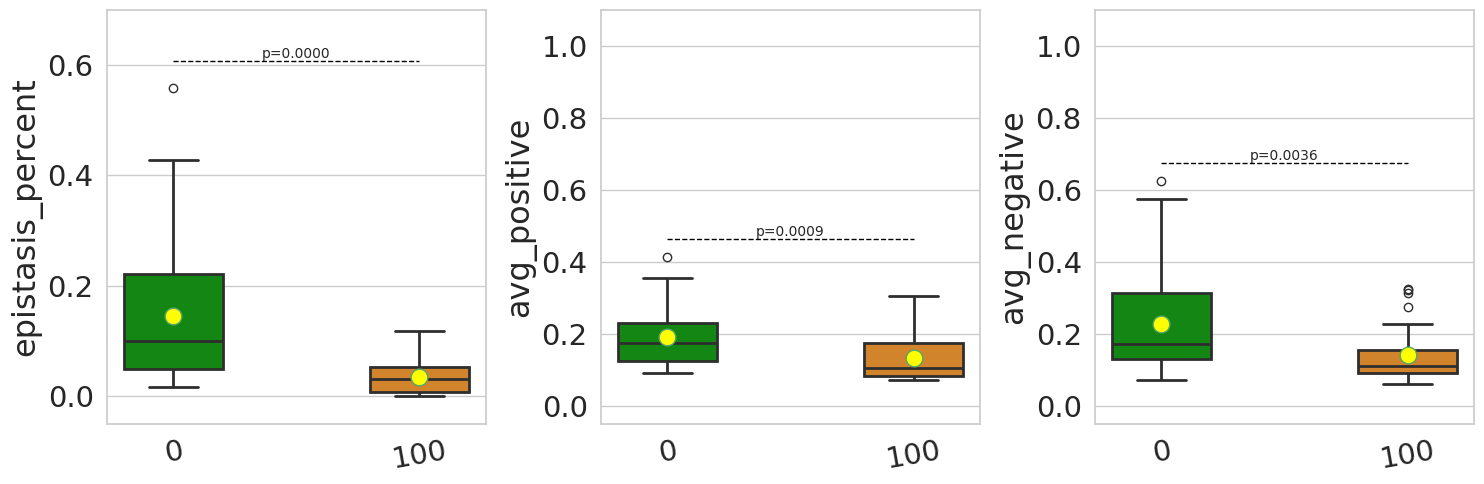

>>>>> symmetry
>> reg10m2


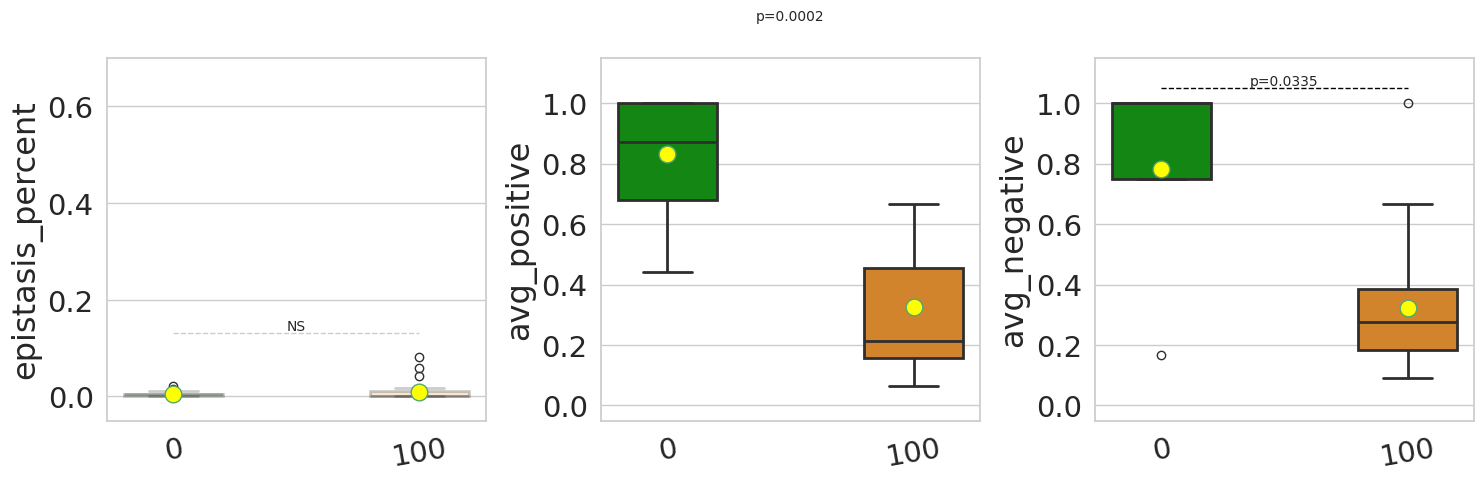

>> reg2m2


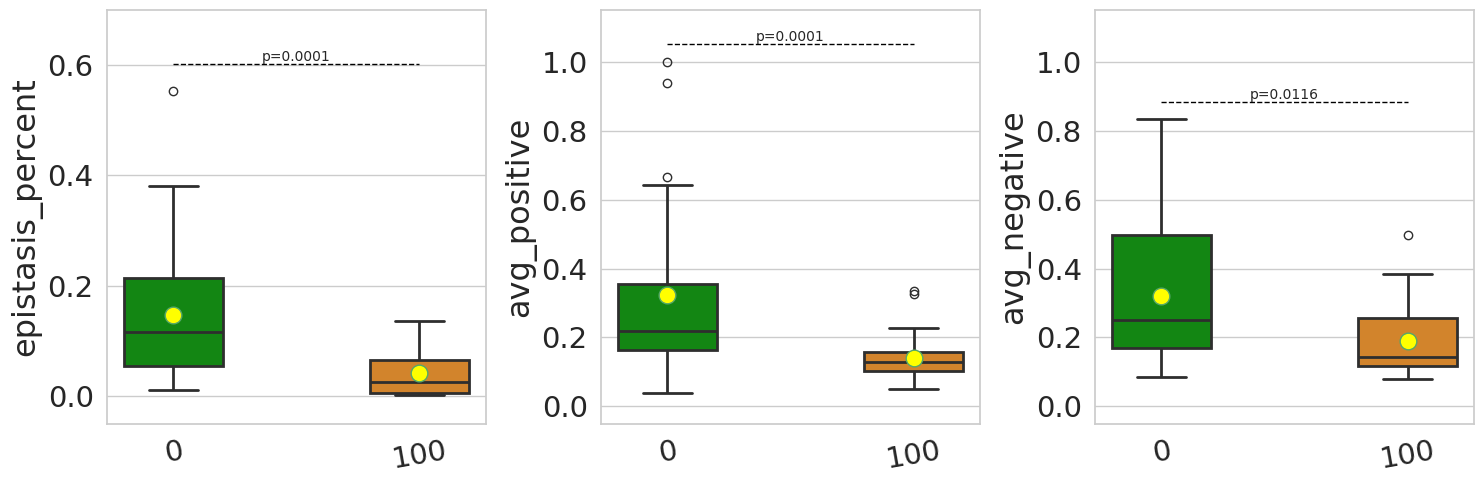

>>>>> proportion
>> reg10m2


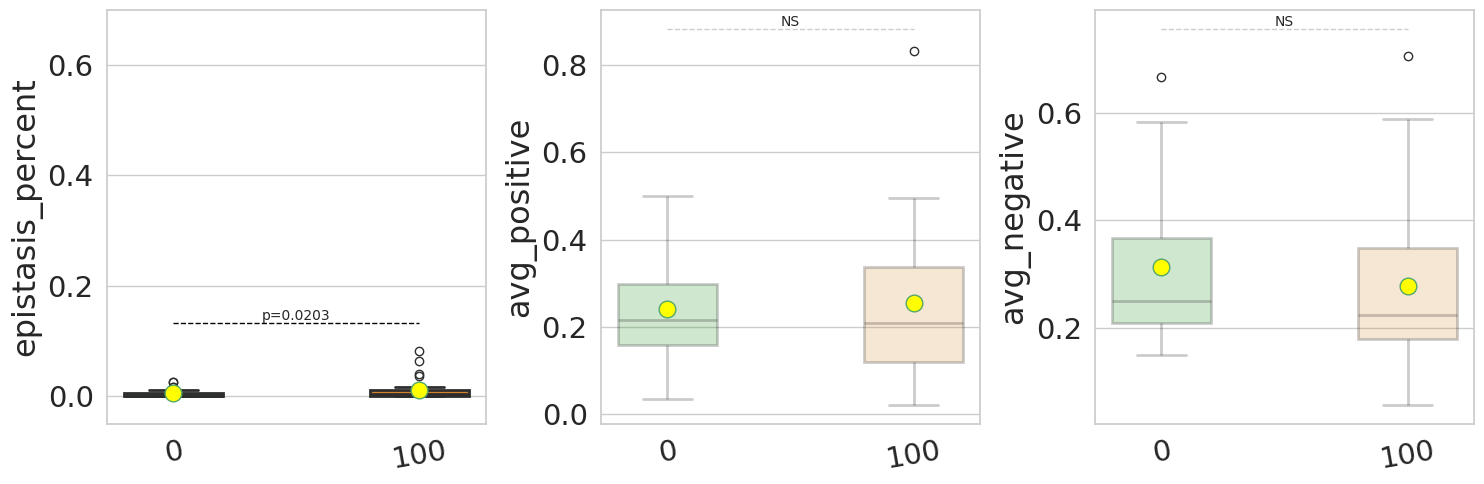

>> reg2m2


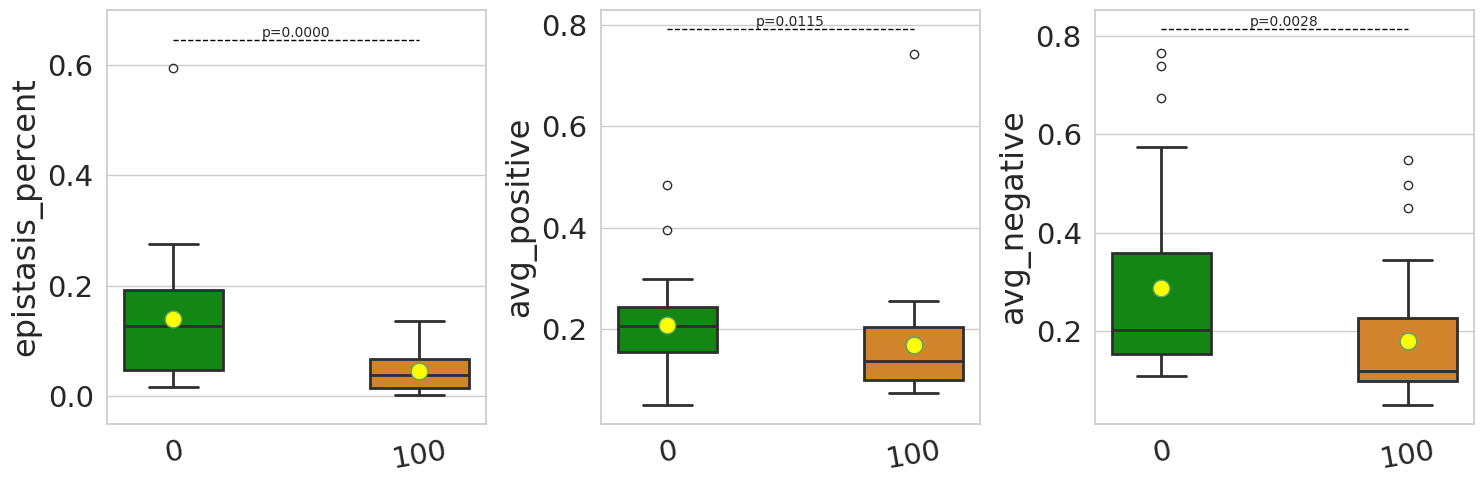

>>>>> coverage
>> reg10m2


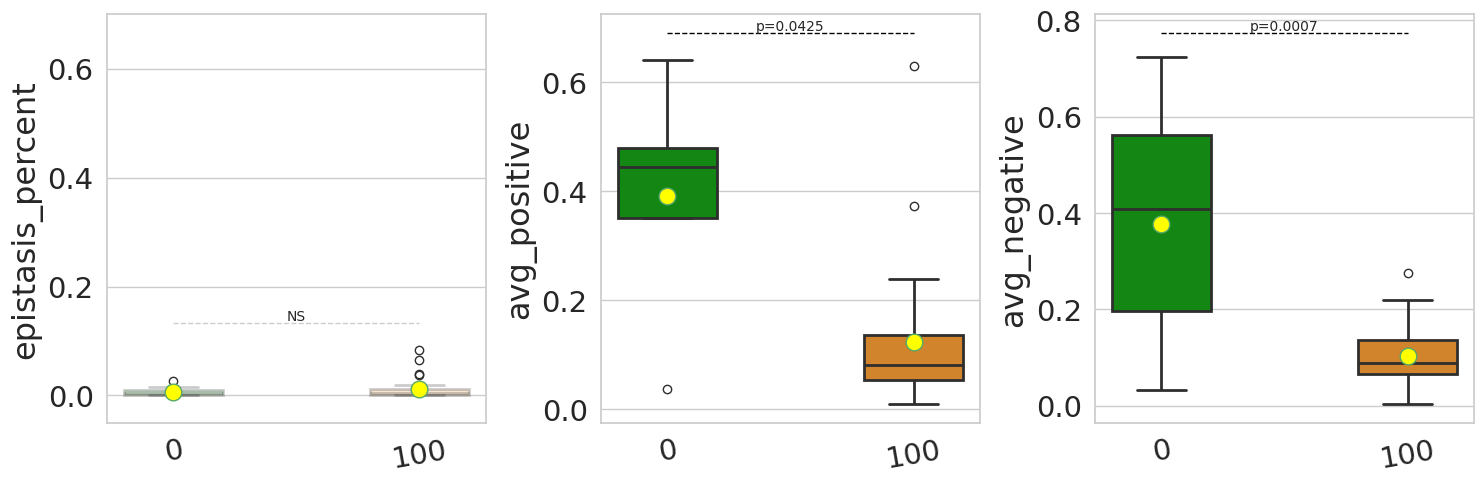

>> reg2m2


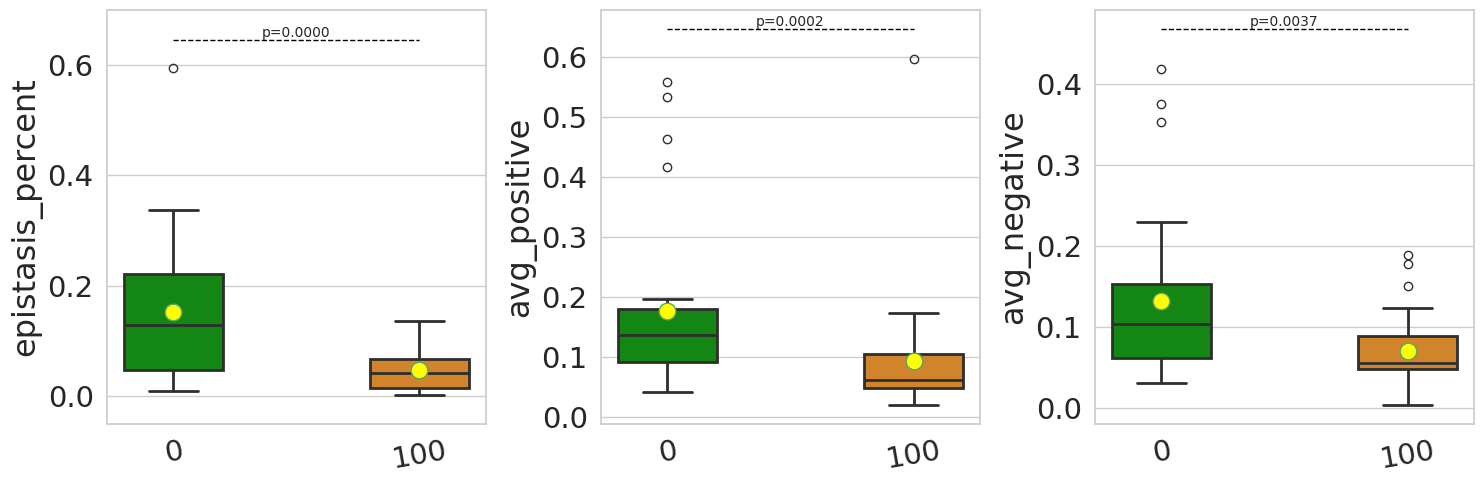

>>>>> extensiveness_prop
>> reg10m2


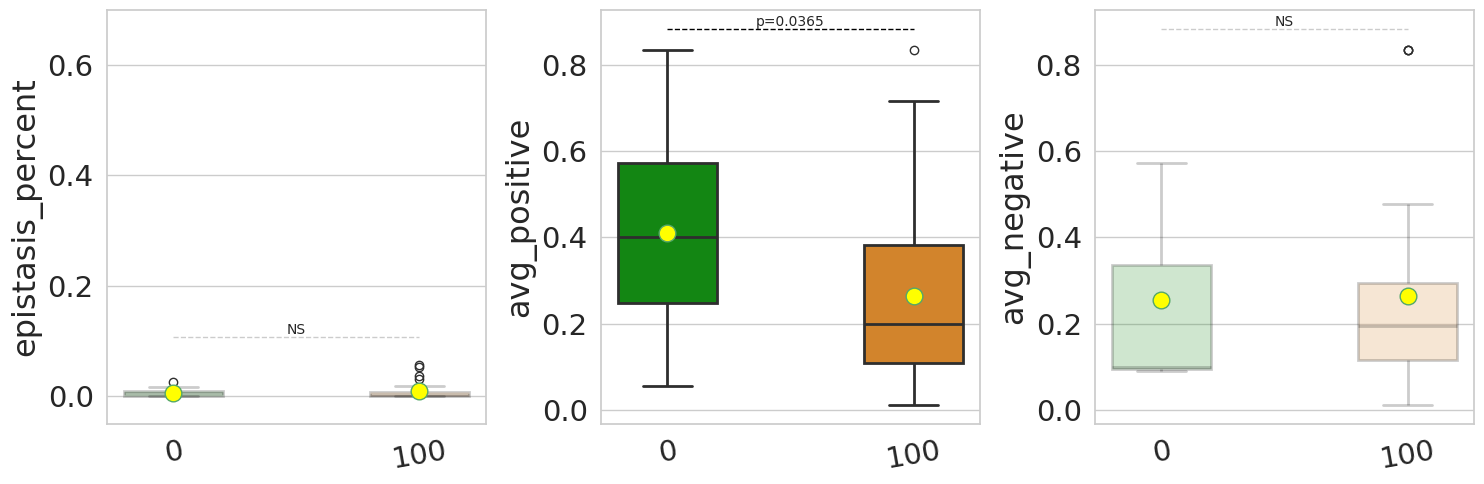

>> reg2m2


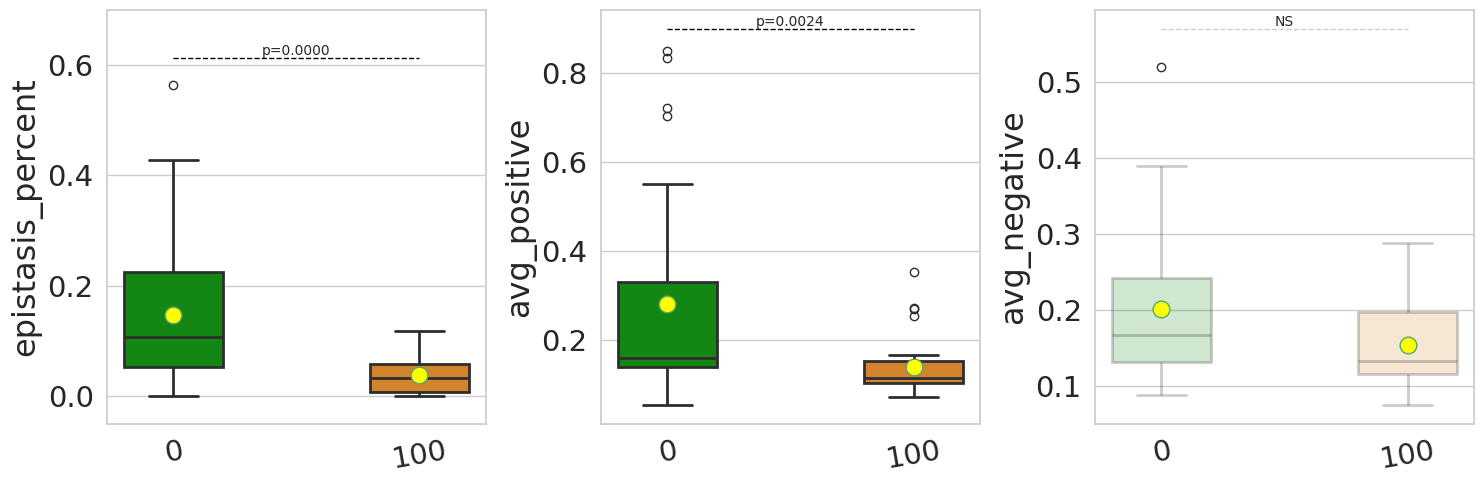

>>>>> branching_prop
>> reg10m2


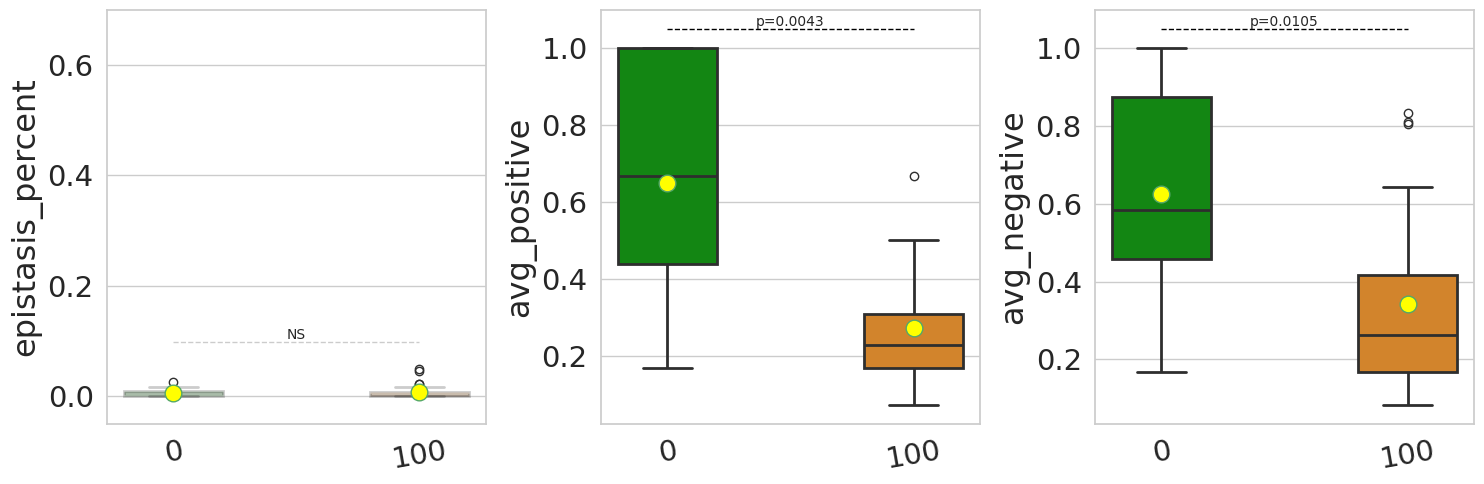

>> reg2m2


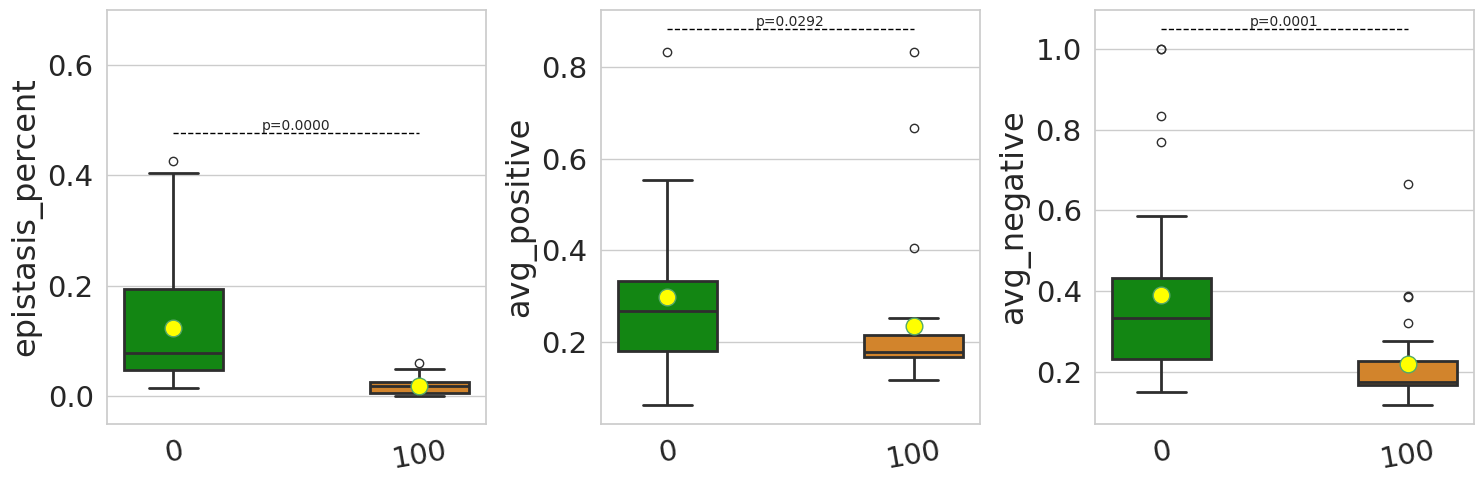

>>>>> modules_count
>> reg10m2


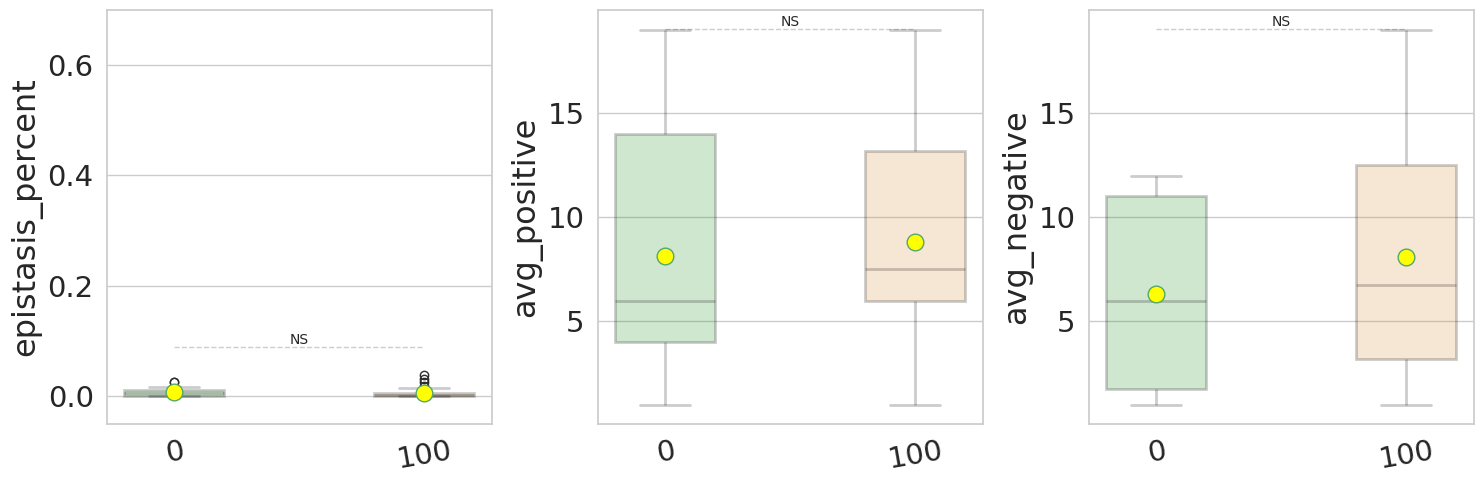

>> reg2m2


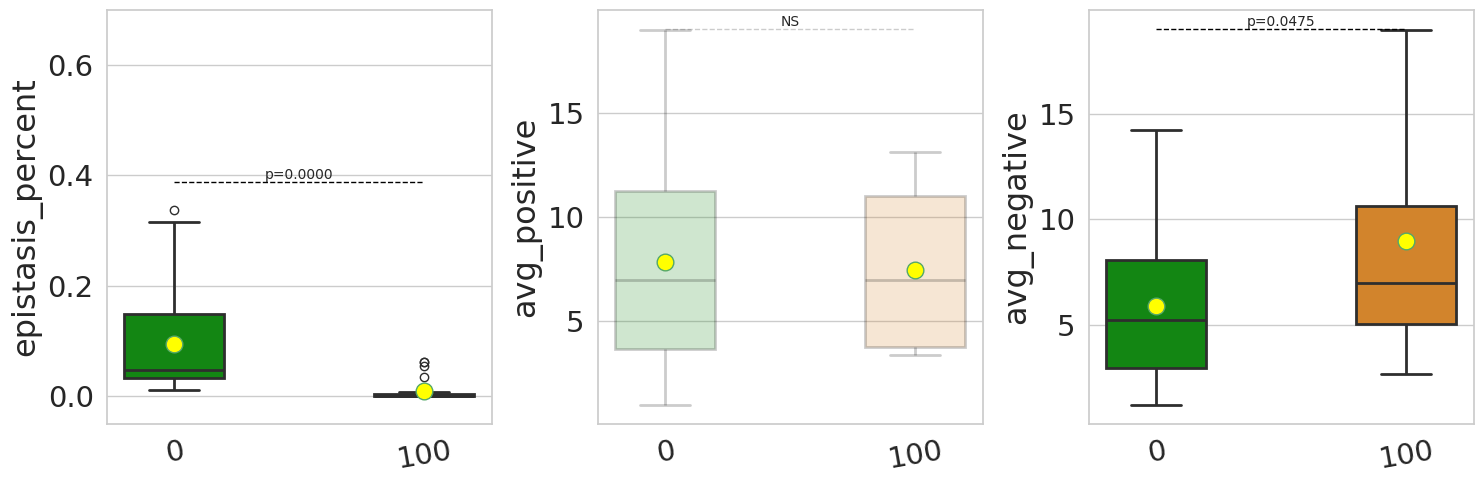

>>>>> hinge_prop
>> reg10m2


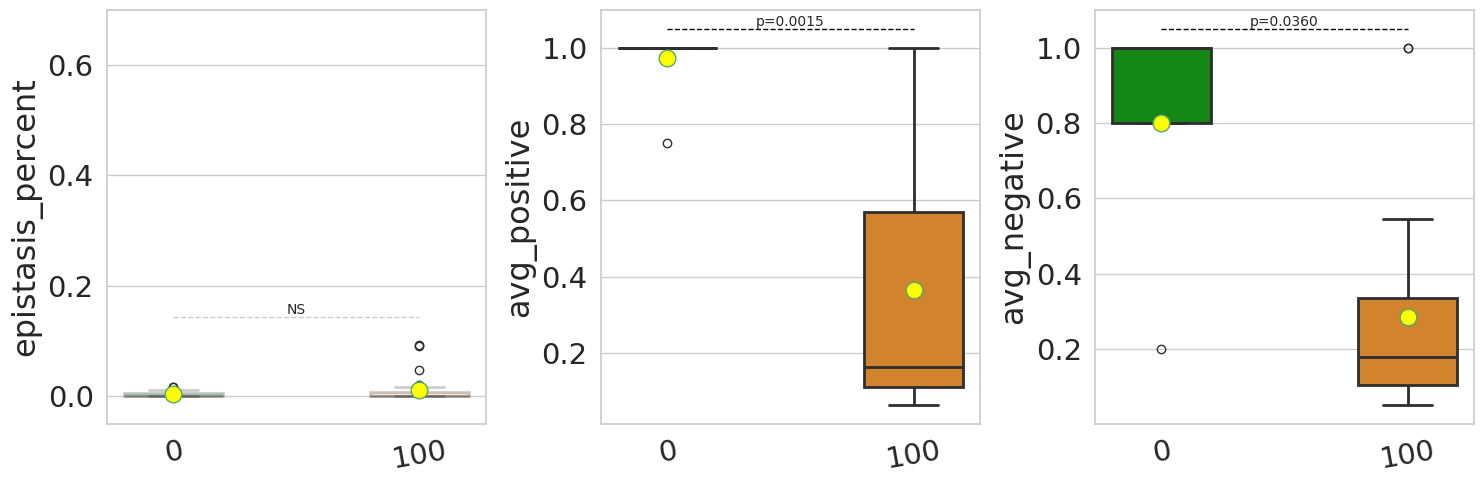

>> reg2m2


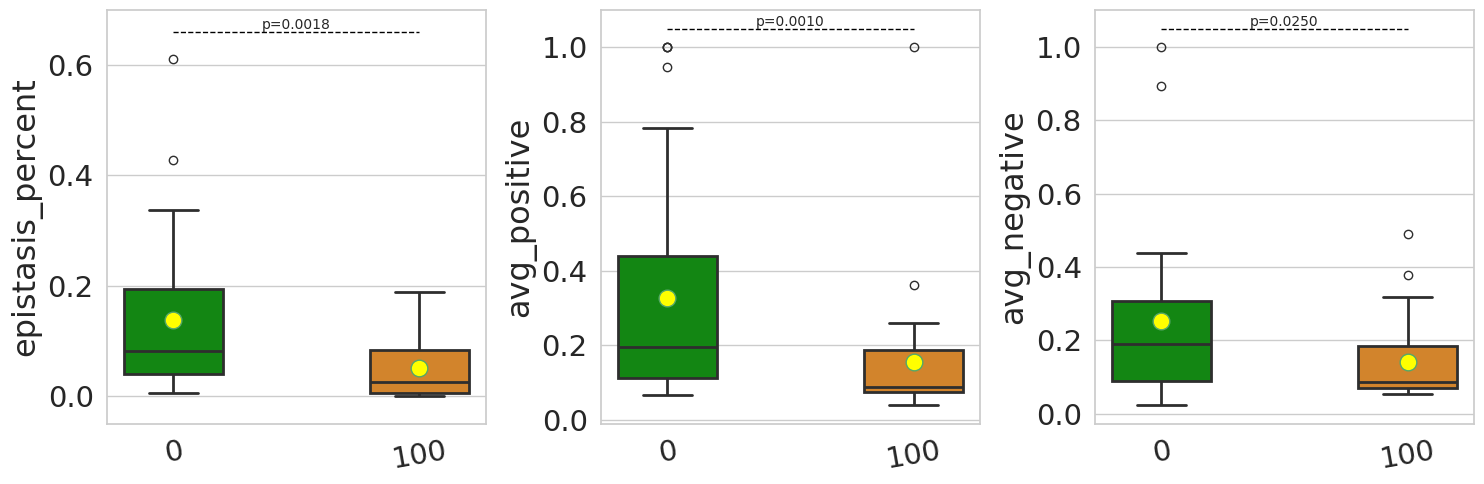

In [27]:


### EPISTASIS CHANGES g1/g100: raw data ###

clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_traits[trait].copy(deep=True)
    

    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
           # print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)

            y_max = filtered_clean[f'{metric}'].max() + 0.05  #
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
            
            if metric in ['epistasis_percent']:
                ax.set_ylim(-0.05, 0.7)

            if metric == 'avg_positive' or metric == 'avg_negative':
                if trait in avg_pos_scale.keys():
                    ax.set_ylim(avg_pos_scale[trait][0], avg_pos_scale[trait][1])
      
            ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')
       
        plt.tight_layout()
        plt.show()







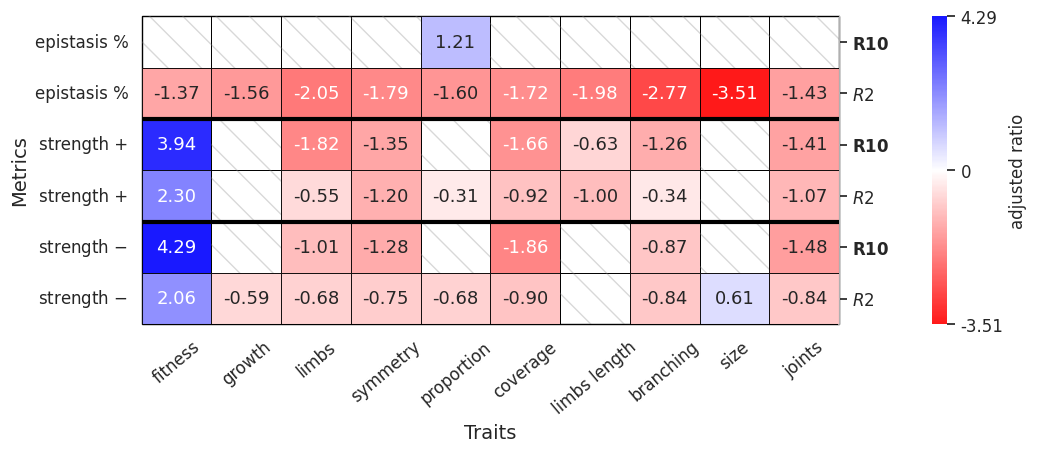

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.patches as patches

generations = [0, 100]

# Store ratio values for each metric, trait, and generation
heatmap_data = np.zeros((len(metrics) * len(experiments), len(traits)))
heatmap_p = np.zeros((len(metrics) * len(experiments), len(traits)))
annot_data = np.empty((len(metrics) * len(experiments), len(traits)), dtype=object)

row_labels = []
exp_labels_local = []

for i, metric in enumerate(metrics):
    for exp_idx, exp in enumerate(experiments):
        row_index = i * len(experiments) + exp_idx
        row_labels.append(f"{metric}")
        
        if exp == 'reg10m2':
            exp_labels_local.append(rf'$\mathbf{{{exp_labels[exp_idx]}}}$')
        else:
            exp_labels_local.append(rf'$\mathit{{{exp_labels[exp_idx]}}}$')
        
        for j, trait in enumerate(traits):
            df_trait = df_traits[trait].copy(deep=True)
            df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            # Calculate the averages
            avg_ini_gen = ini_gen.mean()
            avg_end_gen = end_gen.mean()

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')

            # Calculate the ratio of gen 100 by gen 0
         #   perc = (( avg_end_gen/ avg_ini_gen)-1) * 100
            log2_tansf = round(np.log2(avg_end_gen/ avg_ini_gen),2)

            # Store in heatmap data
            heatmap_data[row_index, j] = log2_tansf
            heatmap_p[row_index, j] = p_value
           # annot_data[row_index, j] =  f"{perc:.0f}%"
            annot_data[row_index, j] =  f"{log2_tansf:.2f}"


# Ensure finite values
heatmap_data = np.nan_to_num(heatmap_data, nan=0, posinf=np.nanmax(heatmap_data[np.isfinite(heatmap_data)]), neginf=np.nanmin(heatmap_data[np.isfinite(heatmap_data)]))

# Determine dynamic min and max values for normalization
vmin = np.min(heatmap_data)
vmax = np.max(heatmap_data)

# Create a colormap transitioning from red (negative values) to white (zero) to green (positive values)
cmap = LinearSegmentedColormap.from_list(    "red_white_blue", ["red", "#ffffff", "blue"])

# Normalize the colormap with zero as the midpoint
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Create mask for non-significant values
mask_pvalue = heatmap_p > 0.05

fig, ax = plt.subplots(figsize=(12, 4))

# Plot the consolidated heatmap
sns.heatmap(
    heatmap_data, annot=annot_data, fmt="",
    cmap=cmap, linewidths=0.5, linecolor='black',
    alpha=0.9, annot_kws={'size': 13},
    xticklabels=traits, yticklabels=row_labels,
    ax=ax, mask=mask_pvalue, norm=norm,
    #cbar_kws={'label': r'Percentage difference ', 'pad': 0.1}
    cbar_kws={'label': r'adjusted ratio', 'pad': 0.1}
)

# Overlay crosshatching for non-significant p-values (p > 0.05)
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        if mask_pvalue[i, j]:
            rect = patches.Rectangle(
                (j, i), 1, 1, linewidth=0, edgecolor='grey',
                facecolor='none', hatch='\\' , alpha=0.3
            )
            ax.add_patch(rect)

# Remove grid lines
ax.set_xticks(ax.get_xticks(), minor=True)
ax.grid(False)

# Set x tick labels
ax.set_xticklabels(traits_labels, rotation=40, fontsize=12)

# Adjust y-axis labels
ax.set_yticklabels(np.repeat(metric_labels, 2), rotation=0, ha='right', fontsize=12)
ax2 = ax.secondary_yaxis('right')
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(exp_labels_local, rotation=0, ha='left', fontsize=12)

# Adjust color bar tick and label sizes
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(12)

# Ensure thick separating lines every two rows
for y in range(2, heatmap_data.shape[0], 2):
    ax.axhline(y=y, color='black', linewidth=3)

# Ensure bottom margin border is present
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)


# Set the ticks and labels for the colorbar
#colorbar_ticks = [-91,0,1859] 
colorbar_ticks = [-3.51, 0, 4.29] 
cbar.set_ticks(colorbar_ticks)
#cbar.set_ticklabels([f"{int(tick)}%" for tick in colorbar_ticks])
cbar.set_ticklabels([f"{tick}" for tick in colorbar_ticks])

plt.xlabel("Traits",fontsize=14)
plt.ylabel("Metrics",fontsize=14)

# Show the plot
plt.show()

# Save the figure
fig.savefig(f'{path}/knockouts/epistasis_change_G100G0.png', dpi=300, bbox_inches='tight')


>> reg10m2


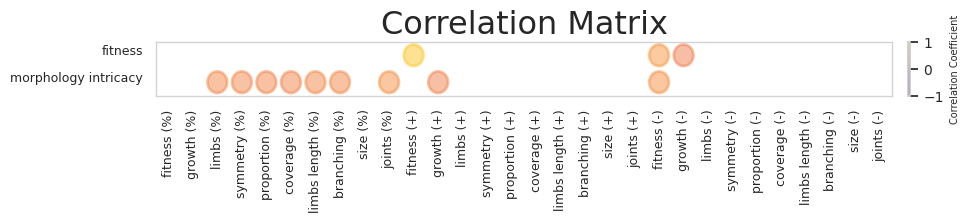

>> reg2m2


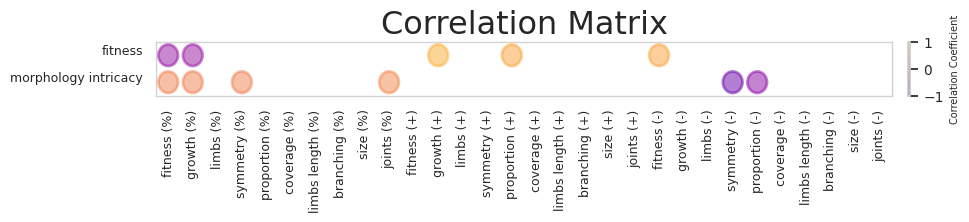

In [29]:
### CORRELATIONS: EPISTASIS VS PHENOCOMPLEXITY

df_complexity_end = df_complexity_all[(df_complexity_all['gen'] == 100)]

metrics1 = ['complexity_env', 'disp_y'] 
additional_columns = []
metrics2 = []
metrics2_adjusted = []
metrics1_adjusted = [  'morphology intricacy', 'fitness'] 

additional_columns_adjusted = []

for idx,trait in enumerate(traits):

    df_trait = df_traits[trait].copy(deep=True) 
    df_trait = df_trait.drop(columns=['Unnamed: 0'])

    corr_df = pd.merge(df_complexity_end, df_trait, on=keys, how='inner')
    corr_df = corr_df.rename(columns={'epistasis_percent': 'epistasis_percent_'+trait, 
                                      'avg_positive': 'avg_positive_'+trait, 
                                      'avg_negative': 'avg_negative_'+trait})
    metrics2.append('epistasis_percent_'+trait)
    metrics2.append('avg_positive_'+trait)
    metrics2.append('avg_negative_'+trait)
    metrics2_adjusted.append(traits_labels[idx]+' (%)')
    metrics2_adjusted.append(traits_labels[idx]+ ' (+)')
    metrics2_adjusted.append(traits_labels[idx]+ ' (-)')
   
    obsolete_vars = ['symmetry', 'extremities_prop' ,'neutral', 'positive', 'negative', 'epistasis']
    redudant_vars = [ 'ranking', 'disp_y', 'geno_size', 'n_genes' ,'complexity_env',
                     'complexity_branch', 'complexity_net', 'interactions_density', 'zero_regulators']

    if idx == 0:
        corr_df_all = corr_df.drop(columns=obsolete_vars)
    else:
        corr_df = corr_df.drop(columns=obsolete_vars+redudant_vars)
        corr_df_all = pd.merge(corr_df_all, corr_df, on=keys, how='inner')
  
for idx_experiment, exp in enumerate(experiments):
    print('>>', exp)
    df_complexity_end_exp = corr_df_all[(corr_df_all['experiment_name'] == exp)]
    df_complexity_end_exp = df_complexity_end_exp[ (df_complexity_end_exp['ranking'] == 'best') ] 
    df_complexity_end_exp[df_complexity_end_exp.select_dtypes(include=['number']).columns] = \
                df_complexity_end_exp.select_dtypes(include=['number']).fillna(0)

    def darken_color(color, factor=0.5):
        r, g, b, a = mcolors.to_rgba(color)
        return mcolors.to_hex((r * factor, g * factor, b * factor, a))
    
    # Function to calculate correlation and p-values
    def calculate_corr_and_pvalues(df):
        corr_matrix = df.corr()
        p_values = pd.DataFrame(np.zeros_like(corr_matrix, dtype=float), index=corr_matrix.index, columns=corr_matrix.columns)
        
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                if i != j:
                    corr, p_value = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
                    p_values.iloc[i, j] = p_value
                    if p_value < 0.05:
                        pass
                        #print(corr_matrix.columns[i], corr_matrix.columns[j], corr, p_value)
                else:
                    p_values.iloc[i, j] = np.nan  # No p-value for self-correlation
    
        return corr_matrix, p_values
    


    # Compute correlations and p-values
    corr_matrix, p_values = calculate_corr_and_pvalues(df_complexity_end_exp[metrics1 + metrics2])
    
    original_names = metrics1 + metrics2 + additional_columns
    adjusted_names = metrics1_adjusted + metrics2_adjusted + additional_columns_adjusted
    rename_mapping = {original: adjusted for original, adjusted in zip(original_names, adjusted_names)}
    
    corr_matrix = corr_matrix.rename(columns=rename_mapping, index=rename_mapping)
    p_values = p_values.rename(columns=rename_mapping, index=rename_mapping)
    
    # Reorder metrics2_adjusted
    percent_labels = [label for label in metrics2_adjusted if '(%)' in label]
    plus_labels = [label for label in metrics2_adjusted if '(+)' in label]
    minus_labels = [label for label in metrics2_adjusted if '(-)' in label]
    
    metrics2_adjusted_sorted = percent_labels + plus_labels + minus_labels + additional_columns_adjusted
    
    # Select the relevant portion of the correlation matrix with reordered x-axis
    corr_matrix = corr_matrix.loc[metrics1_adjusted, metrics2_adjusted_sorted]
    p_values = p_values.loc[metrics1_adjusted, metrics2_adjusted_sorted]
    
    # Create a mask for significant correlations
    significance_mask = p_values < 0.05

    
    # Create a color map from blue to red
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'blue_red',
        ['blue', 'white', 'red'],
        N=256
    )
    cmap = plt.get_cmap('plasma')
    
    # Plotting ########
    plt.figure(figsize=(10, 0.7))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('#D3D3D3')   # Set the color for all spines
        spine.set_linewidth(1) 
    
    # Draw the circles for significant correlations
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            if significance_mask.iloc[i, j]:

                rect_color = cmap((corr_matrix.iloc[i, j] + 1) / 2)  # Normalize correlation to [0, 1]
                border_color = darken_color(rect_color, factor=0.7)  # Darken the fill color for border

                rect = plt.Circle((j, i),  0.40, color=rect_color, alpha=0.5, edgecolor=border_color, linewidth=2, zorder=10)
                ax.add_patch(rect)
             #   plt.text(j , i + 0.2, f'{corr_matrix.iloc[i, j]:.2f}', color='black',     ha='center', va='center', fontsize=6, zorder=20)

    # Set the labels and limits
    plt.xticks(ticks=np.arange(len(corr_matrix.columns)) , labels=corr_matrix.columns, rotation=90, fontsize=9)
    plt.yticks(ticks=np.arange(len(corr_matrix.index))+0.2  , labels=corr_matrix.index, fontsize=9)
   
    plt.xlim(-0.5, len(corr_matrix.columns) - 0.5)
    plt.ylim(len(corr_matrix.index) - 0.5, -0.5)

    plt.title('Correlation Matrix')
    plt.grid(False)
    plt.gca().invert_yaxis()

    # Create and add color bar
    norm = mcolors.Normalize(vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Correlation Coefficient', fontsize=7)
    
    plt.savefig(f'{path}/knockouts/corr_{exp}.png', dpi=300, bbox_inches='tight')
    plt.show()



 >>>>> metrics_dist n_genes

   >>> metric_order avg_positive_disp_y

 -- reg10m2
Average first : 97.8
Average second : 131.0
  p-value: 0.0134


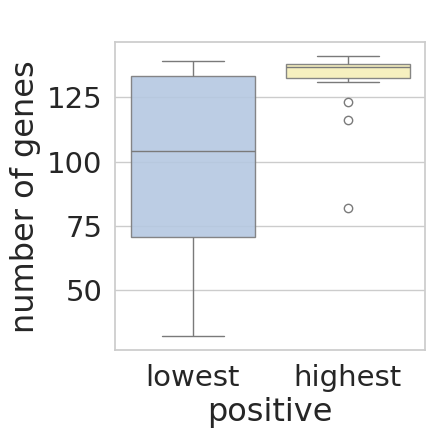


 -- reg2m2
Average first : 92.26666666666667
Average second : 117.2
  p-value: 0.0418


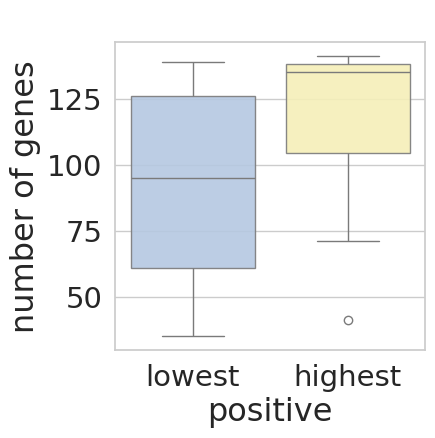


   >>> metric_order avg_negative_disp_y

 -- reg10m2
Average first : 105.6
Average second : 123.2
  p-value: 0.2446


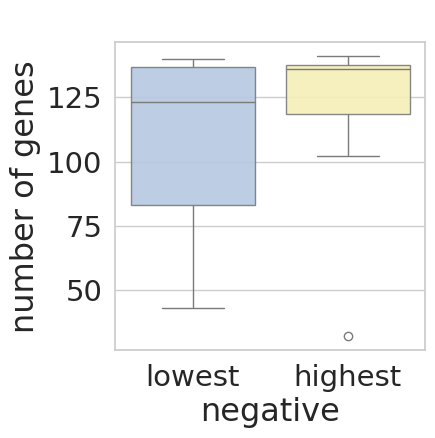


 -- reg2m2
Average first : 110.33333333333333
Average second : 99.13333333333334
  p-value: 0.4672


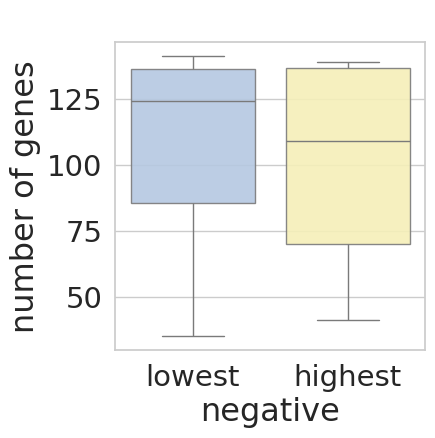


 >>>>> metrics_dist disp_y

   >>> metric_order avg_positive_disp_y

 -- reg10m2
Average first : 1.1605089848590682
Average second : 1.9608992196541901
  p-value: 0.0004


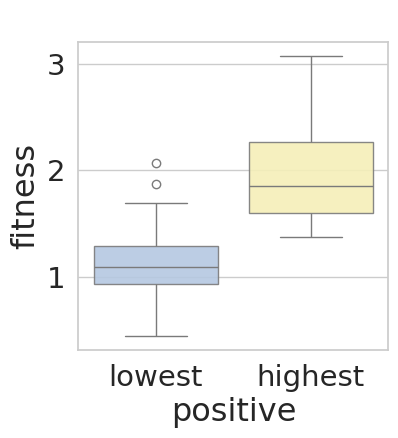


 -- reg2m2
Average first : 2.058426174079068
Average second : 2.2239852293161664
  p-value: 0.1466


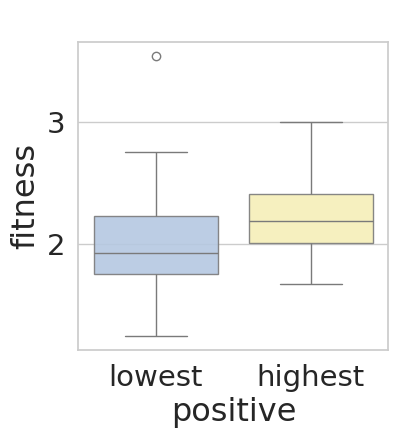


   >>> metric_order avg_negative_disp_y

 -- reg10m2
Average first : 1.2530223894079737
Average second : 1.8683858151052846
  p-value: 0.0062


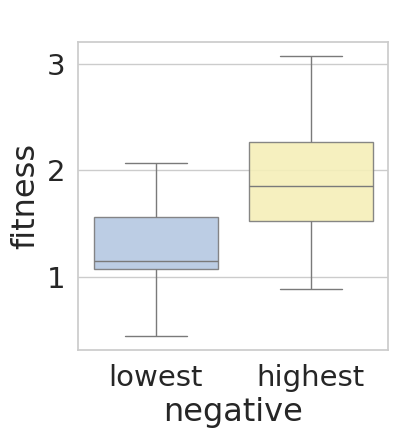


 -- reg2m2
Average first : 2.04878273292755
Average second : 2.2336286704676853
  p-value: 0.2808


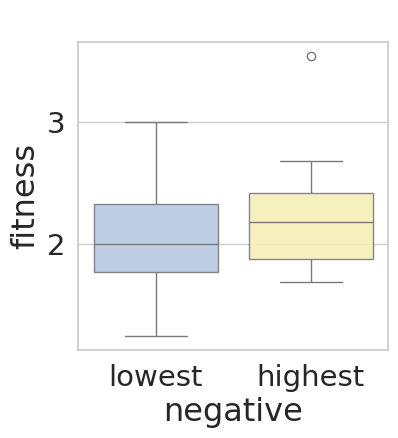

In [37]:

### epistais vs fit


metrics_dist = ['n_genes','disp_y']
metrics_dist_l = ['number of genes','fitness']
metrics_order = ['avg_positive_disp_y', 'avg_negative_disp_y']#,'epistasis_percent_disp_y' ]
metrics_order_l = ['positive', 'negative']

for md_i, metric_dist in enumerate(metrics_dist):
   
    print(f'\n >>>>> metrics_dist',metric_dist)
    for mi, metric_order in enumerate(metrics_order):
        print(f'\n   >>> metric_order',metric_order)
        for exp in experiments:
            print('\n --',exp)
            df_comp_g = corr_df_all[ (corr_df_all['experiment_name'] == exp) ] 
            df_comp_g[df_comp_g.select_dtypes(include=['number']).columns] = \
                    df_comp_g.select_dtypes(include=['number']).fillna(0)
            df_comp_g = df_comp_g[ (df_comp_g['ranking'] == 'best') ] 
            df_sorted = df_comp_g.sort_values(by=metric_order).reset_index(drop=True)
                   
    
            midpoint = len(df_sorted) // 2
            first_half = df_sorted.iloc[:midpoint]
            second_half = df_sorted.iloc[midpoint:]
            
            # Calculate and display the averages for 'b' in each half
            avg_first_half = first_half[metric_dist].mean()
            avg_second_half = second_half[metric_dist].mean()
     
            print(f"Average first : {avg_first_half}")
            print(f"Average second : {avg_second_half}")
            
            _, p_value = mannwhitneyu(first_half[metric_dist], second_half[metric_dist], alternative='two-sided')
            print(f"  p-value: {round(p_value, 4)}")
            
            # Add a new column to each half to indicate "First Half" or "Second Half"
            first_half['half'] = 'lowest'
            second_half['half'] = 'highest'
            
            #  Concatenate the two halves back into a single DataFrame
            df_concat = pd.concat([first_half, second_half], ignore_index=True)
            
            # Plot variable 'disp_y' for each half using box plots
            plt.figure(figsize=(4, 4))
            sb.boxplot(x='half', y=metric_dist, data=df_concat, palette=["#aec7e8", "#fff7ae"], boxprops=dict(alpha=0.9) )

            plt.xlabel(metrics_order_l[mi])
            plt.ylabel(metrics_dist_l[md_i])
            plt.title(' ')
            plt.savefig(f'{path}/knockouts/epis_fit_{metric_order}_{exp}_{metric_dist}.png', dpi=300, bbox_inches='tight')
            plt.show() 


>>>>> disp_y
>> reg10m2
120
48


Unnamed: 0 experiment_name  run  gen ranking  individual_id  buffering  \
0             0         reg10m2    1    0    best             46        NaN   
7             7         reg10m2    2  100   worst           9861        NaN   
8             8         reg10m2    3    0    best             12        NaN   
11           11         reg10m2    3  100   worst          10039        NaN   
14           14         reg10m2    4  100    best           9807        NaN   
23           23         reg10m2    6  100   worst           9982        NaN   
24           24         reg10m2    7    0    best             22        NaN   
25           25         reg10m2    7    0   worst             47        NaN   
28           28         reg10m2    8    0    best             20        NaN   
29           29         reg10m2    8    0   worst             89        NaN   
32           32         reg10m2    9    0    best             87        NaN   
33           33         reg10m2    9    0   worst             55        NaN   
35           35         reg10m2    9  100   worst          10096        NaN   
37           37         reg10m2   10    0   worst             34        NaN   
44           44         reg10m2   12    0    best             80        NaN   
48           48         reg10m2   13    0    best             95        NaN   
50           50         reg10m2   13  100    best           9869        NaN   
52           52         reg10m2   14    0    best             17        NaN   
54           54         reg10m2   14  100    best           9507        NaN   
56           56         reg10m2   15    0    best             41        NaN   
57           57         reg10m2   15    0   worst             16        NaN   
61           61         reg10m2   16    0   worst             68        NaN   
64           64         reg10m2   17    0    best             37        NaN   
65           65         reg10m2   17    0   worst             89        NaN   
67           67         reg10m2   17  100   worst           9695        NaN   
68           68         reg10m2   18    0    best              4        NaN   
69           69         reg10m2   18    0   worst             28        NaN   
72           72         reg10m2   19    0    best             41        NaN   
73           73         reg10m2   19    0   worst             49        NaN   
75           75         reg10m2   19  100   worst          10086        NaN   
76           76         reg10m2   20    0    best             28        NaN   
77           77         reg10m2   20    0   worst             79        NaN   
79           79         reg10m2   20  100   worst          10053        NaN   
81           81         reg10m2   21    0   worst             99        NaN   
83           83         reg10m2   21  100   worst          10058        NaN   
87           87         reg10m2   22  100   worst          10046        NaN   
88           88         reg10m2   23    0    best             22        NaN   
92           92         reg10m2   24    0    best             62        NaN   
93           93         reg10m2   24    0   worst             41        NaN   
96           96         reg10m2   25    0    best            100        NaN   
97           97         reg10m2   25    0   worst             13        NaN   
105         105         reg10m2   27    0   worst             94        NaN   
108         108         reg10m2   28    0    best             41        NaN   
109         109         reg10m2   28    0   worst             78        NaN   
112         112         reg10m2   29    0    best             76        NaN   
113         113         reg10m2   29    0   worst             71        NaN   
117         117         reg10m2   30    0   worst             11        NaN   
119         119         reg10m2   30  100   worst          10073        NaN   

     suppression  quantitative_buffering  quantitative_suppression  masking  \
0            NaN                     NaN              

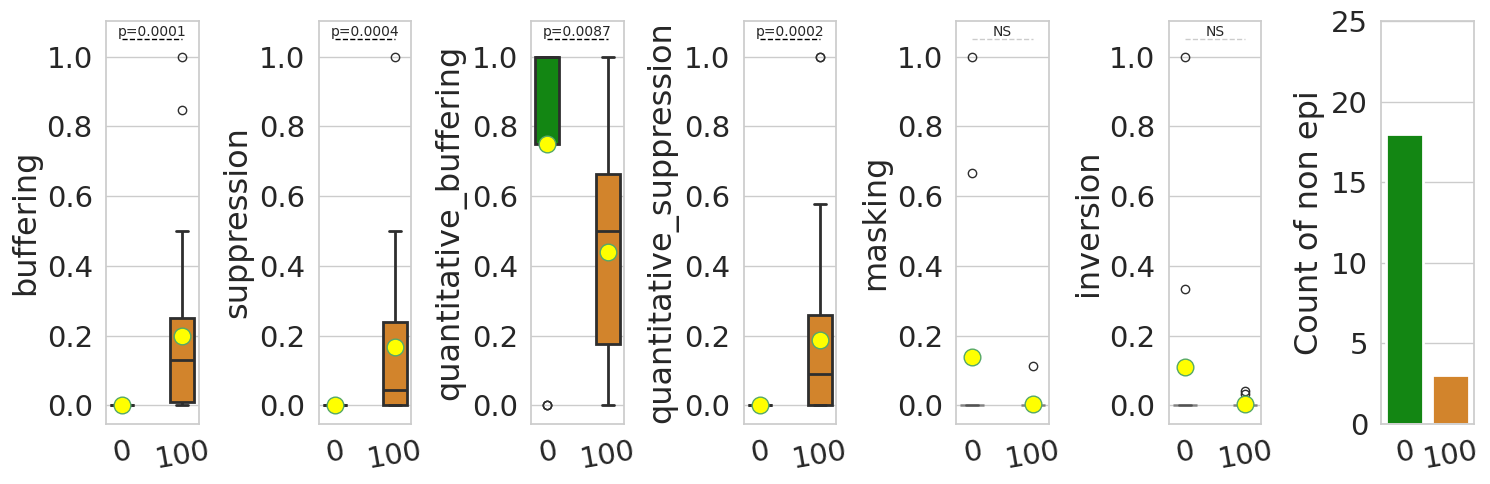

>> reg2m2
120
8


Unnamed: 0 experiment_name  run  gen ranking  individual_id  buffering  \
120         120          reg2m2    1    0    best             38        NaN   
151         151          reg2m2    8  100   worst           9490        NaN   
171         171          reg2m2   13  100   worst           9661        NaN   
175         175          reg2m2   14  100   worst           9902        NaN   
195         195          reg2m2   19  100   worst          10043        NaN   
197         197          reg2m2   20    0   worst             79        NaN   
207         207          reg2m2   22  100   worst           9589        NaN   
225         225          reg2m2   27    0   worst             60        NaN   

     suppression  quantitative_buffering  quantitative_suppression  masking  \
120          NaN                     NaN                       NaN      NaN   
151          NaN                     NaN                       NaN      NaN   
171          NaN                     NaN                       NaN      NaN   
175          NaN                     NaN                       NaN      NaN   
195          NaN                     NaN                       NaN      NaN   
197          NaN                     NaN                       NaN      NaN   
207          NaN                     NaN                       NaN      NaN   
225          NaN                     NaN                       NaN      NaN   

     inversion  epistasis  
120        NaN          0  
151        NaN          0  
171        NaN          0  
175        NaN          0  
195        NaN          0  
197        NaN          0  
207        NaN          0  
225        NaN          0

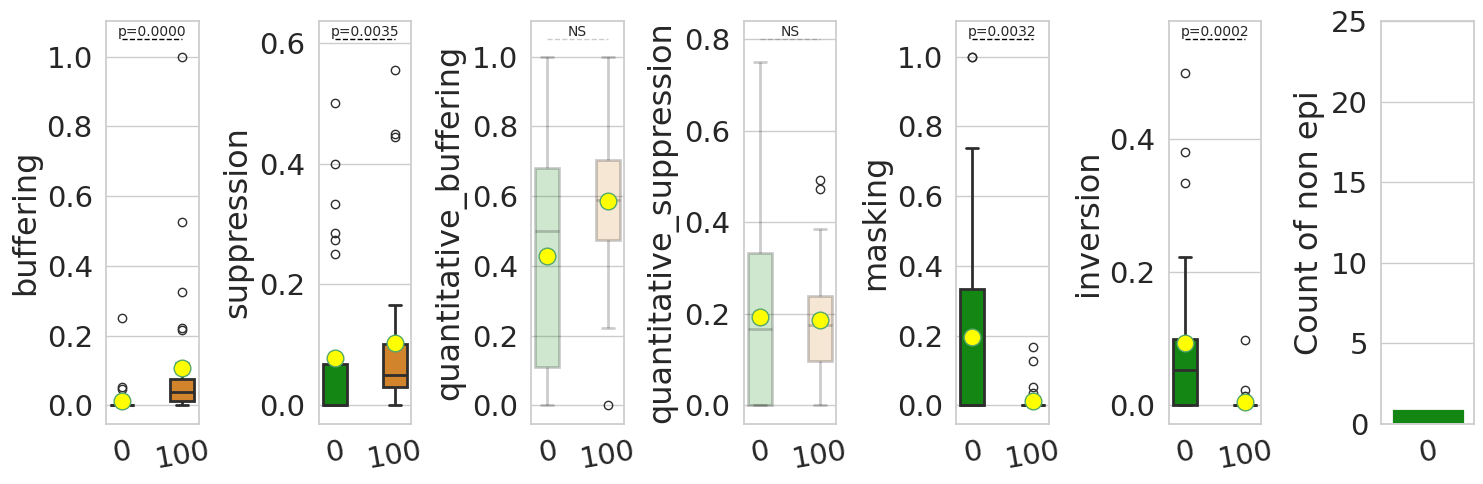

>>>>> distance
>> reg10m2
120
57


Unnamed: 0 experiment_name  run  gen ranking  individual_id  buffering  \
0             0         reg10m2    1    0    best             46        NaN   
8             8         reg10m2    3    0    best             12        NaN   
11           11         reg10m2    3  100   worst          10039        NaN   
12           12         reg10m2    4    0    best             73        NaN   
13           13         reg10m2    4    0   worst             65        NaN   
14           14         reg10m2    4  100    best           9807        NaN   
16           16         reg10m2    5    0    best             79        NaN   
17           17         reg10m2    5    0   worst              3        NaN   
20           20         reg10m2    6    0    best             38        NaN   
24           24         reg10m2    7    0    best             22        NaN   
25           25         reg10m2    7    0   worst             47        NaN   
28           28         reg10m2    8    0    best             20        NaN   
29           29         reg10m2    8    0   worst             89        NaN   
32           32         reg10m2    9    0    best             87        NaN   
33           33         reg10m2    9    0   worst             55        NaN   
35           35         reg10m2    9  100   worst          10096        NaN   
37           37         reg10m2   10    0   worst             34        NaN   
40           40         reg10m2   11    0    best             30        NaN   
44           44         reg10m2   12    0    best             80        NaN   
45           45         reg10m2   12    0   worst             73        NaN   
48           48         reg10m2   13    0    best             95        NaN   
50           50         reg10m2   13  100    best           9869        NaN   
52           52         reg10m2   14    0    best             17        NaN   
53           53         reg10m2   14    0   worst             89        NaN   
54           54         reg10m2   14  100    best           9507        NaN   
57           57         reg10m2   15    0   worst             16        NaN   
64           64         reg10m2   17    0    best             37        NaN   
65           65         reg10m2   17    0   worst             89        NaN   
68           68         reg10m2   18    0    best              4        NaN   
69           69         reg10m2   18    0   worst             28        NaN   
72           72         reg10m2   19    0    best             41        NaN   
73           73         reg10m2   19    0   worst             49        NaN   
75           75         reg10m2   19  100   worst          10086        NaN   
77           77         reg10m2   20    0   worst             79        NaN   
81           81         reg10m2   21    0   worst             99        NaN   
82           82         reg10m2   21  100    best           9169        NaN   
83           83         reg10m2   21  100   worst          10058        NaN   
84           84         reg10m2   22    0    best             20        NaN   
85           85         reg10m2   22    0   worst             23        NaN   
87           87         reg10m2   22  100   worst          10046        NaN   
88           88         reg10m2   23    0    best             22        NaN   
89           89         reg10m2   23    0   worst             87        NaN   
92           92         reg10m2   24    0    best             62        NaN   
93           93         reg10m2   24    0   worst             41        NaN   
96           96         reg10m2   25    0    best            100        NaN   
97           97         reg10m2   25    0   worst             13        NaN   
100         100         reg10m2   26    0    best             53        NaN   
101         101         reg10m2   26    0   worst             22        NaN   
104         104         reg10m2   27    0    best             69        NaN   
105         105         reg10m2   27    0   worst      

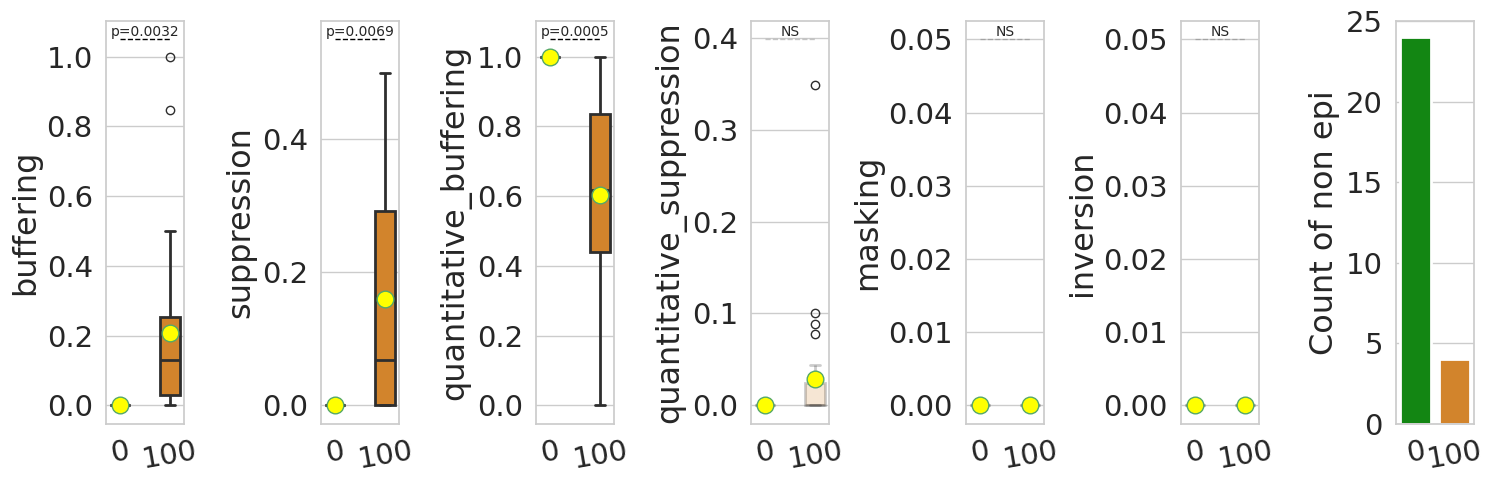

>> reg2m2
120
3


Unnamed: 0 experiment_name  run  gen ranking  individual_id  buffering  \
120         120          reg2m2    1    0    best             38        NaN   
195         195          reg2m2   19  100   worst          10043        NaN   
208         208          reg2m2   23    0    best             27        NaN   

     suppression  quantitative_buffering  quantitative_suppression  masking  \
120          NaN                     NaN                       NaN      NaN   
195          NaN                     NaN                       NaN      NaN   
208          NaN                     NaN                       NaN      NaN   

     inversion  epistasis  
120        NaN          0  
195        NaN          0  
208        NaN          0

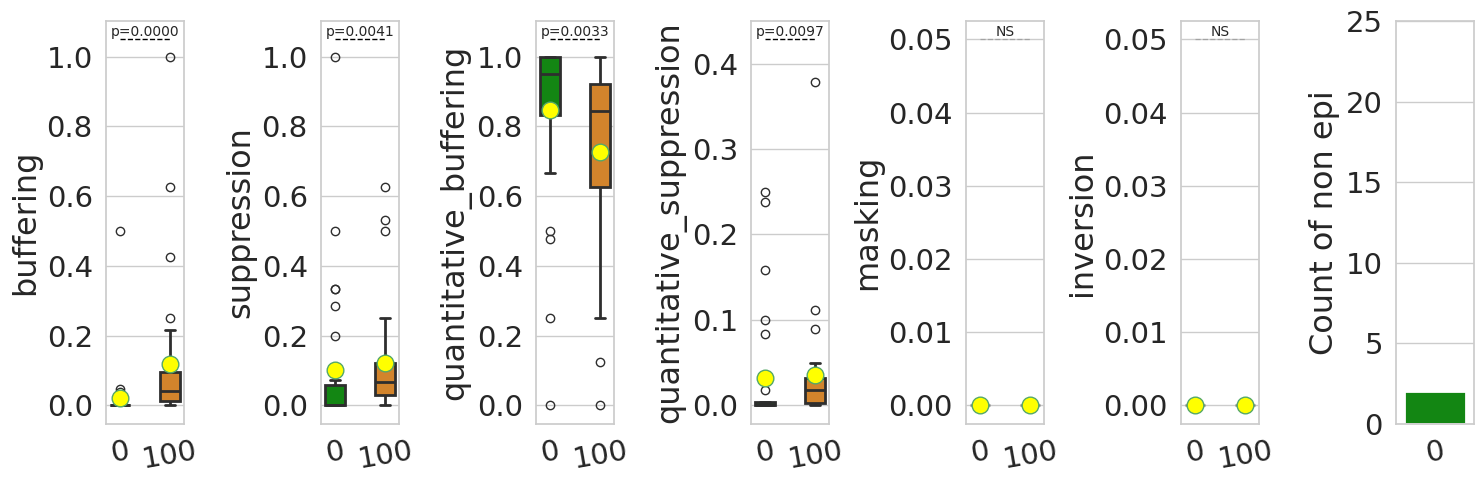

In [58]:
### EPISTASIS CATEG CHANGES ###
traits = ['disp_y', 'distance' ]

metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']

clrs = ['#009900',

        
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
sb.set_style("whitegrid")

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        
        print(len(df_trait_exp))
        zero_metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']
        pd.set_option('display.max_rows', 500)
        filtered_df = df_trait_exp[
            (df_trait_exp['epistasis'] ==0) #&
           # (df_trait_exp[zero_metrics] ==0 ).all(axis=1)
        ]

        print(len(filtered_df))
        display(filtered_df)
    
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 

        df_trait_exp_zero = df_trait_exp[ (df_trait_exp['epistasis'] == 0) ] 
        df_trait_exp = df_trait_exp[ (df_trait_exp['epistasis'] > 0) ] 
       
        df_trait_exp[metrics] = df_trait_exp[metrics].fillna(0)
        
        fig, axes = plt.subplots(1, 7, figsize=(15, 5))  #
       
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
            #print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
    
            y_max = filtered_clean[f'{metric}'].max() + 0.05             
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
      
            ax.tick_params(axis='x', labelrotation=10)
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')


        ax = axes[idx+1]

        # Create a bar plot to count the number of rows for each 'gen'
        sb.countplot(x='gen', data=df_trait_exp_zero, palette=clrs, linewidth=2, ax=ax)
        
        # Customize the plot
        ax.tick_params(axis='x', labelrotation=10)
        ax.set_xlabel('')
        ax.set_ylabel(f'Count of non epi')
        ax.set_ylim(0, 25) 
        
        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.show()
    


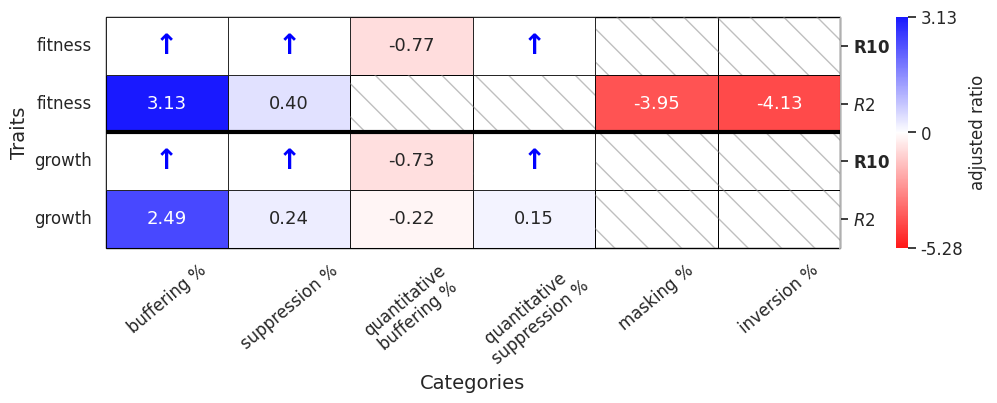

In [527]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
import matplotlib.patches as patches
import math 

generations = [0, 100]

# Store ratio values for each metric, trait, and generation
heatmap_data = np.zeros((len(traits) * len(experiments), len(metrics)))
heatmap_datag0 = np.zeros((len(traits) * len(experiments), len(metrics)))
heatmap_datag100 = np.zeros((len(traits) * len(experiments), len(metrics)))
heatmap_p = np.zeros((len(traits) * len(experiments), len(metrics)))
annot_data = np.empty((len(traits) * len(experiments), len(metrics)), dtype=object)

row_labels = []
exp_labels_local = []

for i, trait in enumerate(traits):
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for k, exp in enumerate(experiments):
        
        row_index = i * len(experiments) + k
        row_labels.append(f"{trait}")
        
        if exp == 'reg10m2':
            exp_labels_local.append(rf'$\mathbf{{{exp_labels[k]}}}$')
        else:
            exp_labels_local.append(rf'$\mathit{{{exp_labels[k]}}}$')
            
        for j, metric in enumerate(metrics):
       
            df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']
            
            # only cases with epistasis: when e vision of the categs freq by 0 results is nan
            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']
    
            # Calculate the averages
            avg_ini_gen = ini_gen.mean()
            avg_end_gen = end_gen.mean()

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
         
            # Calculate the ratio of gen 100 to gen 0
           # perc = (( avg_end_gen/ avg_ini_gen)-1) * 100
            log2_tansf = round(np.log2(avg_end_gen/ avg_ini_gen),2)


            # Store in heatmap data
            heatmap_datag0[row_index, j] = avg_ini_gen
            heatmap_datag100[row_index, j] = avg_end_gen
            
            heatmap_data[row_index, j] = log2_tansf
            heatmap_p[row_index, j] = p_value
          #  annot_data[row_index, j] =  f"{perc:.0f}%"
            annot_data[row_index, j] =  f"{log2_tansf:.2f}"

metrics_labels=['buffering %', 'suppression %' , 'quantitative\nbuffering %', 'quantitative \nsuppression %', 
                'masking %', 'inversion %'] 
#metrics_labels=['buffering (B) %', 'suppression (S) %' , 'quantitative\nbuffering (QB) %', 'quantitative \nsuppression (QS) %', 
               # 'masking (M) %', 'inversion (I) %'] 

traits_labels = traits_labels[0:2]

# Ensure finite values (removing Inf and NaN)
heatmap_data = np.nan_to_num(heatmap_data, nan=0, posinf=np.nan, neginf=np.nan)

# Determine dynamic min and max values for normalization
vmin = np.nanmin(heatmap_data)
vmax = np.nanmax(heatmap_data)

# Create a colormap transitioning from red (negative values) to white (zero) to green (positive values)
cmap = LinearSegmentedColormap.from_list(    "red_white_blue", ["red", "#ffffff", "blue"])


# Normalize the colormap with zero as the midpoint
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Create mask for non-significant values
mask_pvalue = heatmap_p > 0.05

fig, ax = plt.subplots(figsize=(12, 3))

# Plot the consolidated heatmap
sns.heatmap(
    heatmap_data, annot=annot_data, fmt="",
    cmap=cmap, linewidths=0.5, linecolor='black',
    alpha=0.9, annot_kws={'size': 13},
    xticklabels=metrics_labels, yticklabels=row_labels,
    ax=ax, mask=mask_pvalue, norm=norm,
    #cbar_kws={'label': r'Percentage difference ', 'pad': 0.06}
    cbar_kws={'label': r'adjusted ratio', 'pad': 0.06}
)

# Overlay crosshatching for non-significant p-values (p > 0.05)
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        if mask_pvalue[i, j]:
            rect = patches.Rectangle(
                (j, i), 1, 1, linewidth=0, edgecolor='grey',
                facecolor='none', hatch='\\' , alpha=0.5
            )
            ax.add_patch(rect)

# Overlay crosshatching for non-significant p-values (p > 0.05)
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
       # if theres was nothing in that category but now theres something
        if heatmap_datag0[i, j] == 0 and heatmap_datag100[i, j] > 0:
            ax.annotate('↑', (j + 0.5, i + 0.5), color='blue', fontsize=20, ha='center', va='center', fontweight='bold')

            rect = patches.Rectangle(
                (j, i), 1, 1, linewidth=0.5, edgecolor='black',
                facecolor='white', ##0000CC'
            )
            ax.add_patch(rect)

# Remove grid lines
ax.set_xticks(ax.get_xticks(), minor=True)
ax.grid(False)
 
# Set x tick labels to font size 12
ax.set_xticklabels(metrics_labels, rotation=40, fontsize=12)

# Adjust y-axis labels: primary labels (e.g., metric) on the left...
ax.set_yticklabels(np.repeat(traits_labels, 2), rotation=0, ha='right', fontsize=12)
# ...and a secondary y-axis for the generation labels on the right
ax2 = ax.secondary_yaxis('right')
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(exp_labels_local, rotation=0, ha='left', fontsize=12)

# Adjust color bar tick and label sizes
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(12)

# Ensure thick separating lines every two rows
for y in range(2, heatmap_data.shape[0], 2):
    ax.axhline(y=y, color='black', linewidth=3)

# Ensure bottom margin border is present
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

# Set the ticks and labels for the colorbar
#colorbar_ticks = [-50, 0, 100] 
colorbar_ticks = [vmin, 0, vmax] 
cbar.set_ticks(colorbar_ticks)
#cbar.set_ticklabels([f"    " for tick in colorbar_ticks])
cbar.set_ticklabels([f"{tick}" for tick in colorbar_ticks])

# # Add x and y labels with desired font size
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Traits", fontsize=14)

plt.show()
fig.savefig(f'{path}/knockouts/epistasis_categ_change.png', dpi=300, bbox_inches='tight')


>>>>> disp_y
>> reg10m2


Empty DataFrame
Columns: [Unnamed: 0, experiment_name, run, gen, ranking, individual_id, buffering, suppression, quantitative_buffering, quantitative_suppression, masking, inversion, epistasis]
Index: []

The number of rows in df_trait_exp_zero is: 48


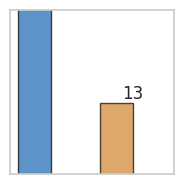

>> reg2m2


Empty DataFrame
Columns: [Unnamed: 0, experiment_name, run, gen, ranking, individual_id, buffering, suppression, quantitative_buffering, quantitative_suppression, masking, inversion, epistasis]
Index: []

The number of rows in df_trait_exp_zero is: 8


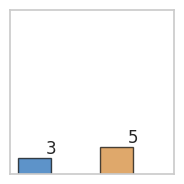

>>>>> distance
>> reg10m2


Empty DataFrame
Columns: [Unnamed: 0, experiment_name, run, gen, ranking, individual_id, buffering, suppression, quantitative_buffering, quantitative_suppression, masking, inversion, epistasis]
Index: []

The number of rows in df_trait_exp_zero is: 57


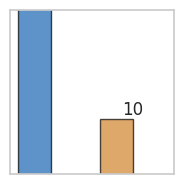

>> reg2m2


Empty DataFrame
Columns: [Unnamed: 0, experiment_name, run, gen, ranking, individual_id, buffering, suppression, quantitative_buffering, quantitative_suppression, masking, inversion, epistasis]
Index: []

The number of rows in df_trait_exp_zero is: 3


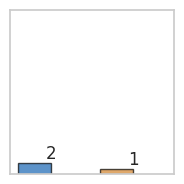

In [50]:

metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']

clrs = ['#0066CC', '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4], 'extremities_prop': [-0.05, 1.1], 'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}


sb.set_style("whitegrid")

for trait in traits:
    print('>>>>>', trait)
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for exp in experiments:
        print('>>', exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
       # df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']
        
        
        df_trait_exp_zero = df_trait_exp[df_trait_exp['epistasis'] == 0]


        zero_metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']
        pd.set_option('display.max_rows', 500)
        filtered_df = df_trait_exp[
            (df_trait_exp['epistasis'] == 0) &
            (df_trait_exp[zero_metrics] ==0).all(axis=1)
        ]
        display(filtered_df)
        
        
        # Count the number of rows in df_trait_exp_zero
        num_rows = df_trait_exp_zero.shape[0]
        print(f'The number of rows in df_trait_exp_zero is: {num_rows}')
        
        if num_rows > 0:
            fig, ax = plt.subplots(1, 1, figsize=(2, 2))

            # Create countplot
            sb.countplot(x='gen', data=df_trait_exp_zero, palette=clrs, linewidth=1, ax=ax, alpha=0.7, edgecolor='black')

            # Set y-axis limit
            ax.set_ylim(0, 30)
            
            # Annotate each bar with its count
            for p in ax.patches:
                height = p.get_height()
                if height > 0:
                    ax.annotate(
                        f'{int(height)}',  # The count
                        (p.get_x() + p.get_width() / 2., height),  # Position at top of bar
                        ha='center', va='bottom',
                        fontsize=12#, fontweight='bold'
                    )
                    
            # Remove x-axis labels
            ax.set_xticklabels([''] * len(ax.get_xticks()))

            # Consistent bar width
            for patch in ax.patches:
                patch.set_width(0.4)  # Adjust width to keep it consistent

            # Add a dummy bar if there's only one bar
            if len(ax.patches) == 1:
                ax.bar(1, 0, width=0.4, color='white', edgecolor='white')  # Invisible bar to maintain spacing

            # Remove y-axis labels
            ax.set_yticklabels([])
            ax.set_xlabel('')
            ax.set_ylabel('')


            
            # Adjust the layout and display the plot
            plt.tight_layout()
            ax.grid(False)
            plt.show()
            
            fig.savefig(f'{path}/knockouts/epistasis_nochange_{trait}_{exp}.png', dpi=300, bbox_inches='tight')

In [16]:
### CORRELATIONS: CATEG EPISTASIS VS PHENOCOMPLEXITY
metrics1 = [ 'complexity_env', 'disp_y']
additional_columns = [] 
metrics2 = []

metrics1_adjusted = [ 'morphology intricacy',  'fitness']
metrics2_adjusted = ['fitness (B)', 'growth (B)',  
                     'fitness (S)', 'growth (S)',
                     'fitness (QB)', 'growth (QB)',
                     'fitness (QS)', 'growth (QS)', 
                     'fitness (M)',  'growth (M)', 
                     'fitness (I)', 'growth (I)',
                    ]
additional_columns_adjusted = []

categs = ['buffering', 'suppression' , 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion'] 

for idx,trait in enumerate(traits):
    df_trait = df_categ_traits[trait].copy(deep=True) 
    df_trait = df_trait.drop(columns=['Unnamed: 0'])

    corr_df = pd.merge(df_complexity_end, df_trait, on=keys, how='inner')

    for categ in categs:
        corr_df = corr_df.rename(columns={categ: f'{categ}_'+trait    })
        
    obsolete_vars = ['symmetry', 'extremities_prop' , 'epistasis']
    redudant_vars = [ 'ranking', 'disp_y', 'geno_size', 'n_genes', 'complexity_env',
                     'complexity_branch', 'complexity_net', 'interactions_density']

    if idx == 0:
        corr_df_all = corr_df.drop(columns=obsolete_vars)
    else:
        corr_df = corr_df.drop(columns=obsolete_vars+redudant_vars)
        corr_df_all = pd.merge(corr_df_all, corr_df, on=keys, how='inner')

metrics2 = []
for categ in categs:
  for idx,trait in enumerate(traits):
      metrics2.append(f'{categ}_' + trait )

for idx_experiment, exp in enumerate(experiments):
    print('>>', exp)
    df_complexity_end_exp = corr_df_all[(corr_df_all['experiment_name'] == exp)]
    df_complexity_end_exp = df_complexity_end_exp[ (df_complexity_end_exp['ranking'] == 'best') ] 
    df_complexity_end_exp[df_complexity_end_exp.select_dtypes(include=['number']).columns] = df_complexity_end_exp.select_dtypes(include=['number']).fillna(0)

    def darken_color(color, factor=0.7):
        r, g, b, a = mcolors.to_rgba(color)
        return mcolors.to_hex((r * factor, g * factor, b * factor, a))
    
    # Function to calculate correlation and p-values
    def calculate_corr_and_pvalues(df):
        corr_matrix = df.corr()
        p_values = pd.DataFrame(np.zeros_like(corr_matrix, dtype=float), index=corr_matrix.index, columns=corr_matrix.columns)
        
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                if i != j:
                    corr, p_value = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
                    p_values.iloc[i, j] = p_value
                    if p_value < 0.05:
                        pass
                       # print(corr_matrix.columns[i], corr_matrix.columns[j], corr, p_value)
                else:
                    p_values.iloc[i, j] = np.nan  # No p-value for self-correlation
    
        return corr_matrix, p_values
    
    
    # Compute correlations and p-values
    corr_matrix, p_values = calculate_corr_and_pvalues(df_complexity_end_exp[metrics1 + metrics2])
    
    original_names = metrics1 + metrics2 + additional_columns
    adjusted_names = metrics1_adjusted + metrics2_adjusted + additional_columns_adjusted
    rename_mapping = {original: adjusted for original, adjusted in zip(original_names, adjusted_names)}


    
    corr_matrix = corr_matrix.rename(columns=rename_mapping, index=rename_mapping)
    p_values = p_values.rename(columns=rename_mapping, index=rename_mapping)
    
    #display(corr_matrix)
    
    # Select the relevant portion of the correlation matrix
    corr_matrix = corr_matrix.loc[metrics1_adjusted, metrics2_adjusted + additional_columns_adjusted]
    p_values = p_values.loc[metrics1_adjusted, metrics2_adjusted + additional_columns_adjusted]
    
    # Create a mask for significant correlations
    significance_mask = p_values < 0.05
    
    # Create a color map from blue to red
    cmap = plt.get_cmap('plasma')

    # Plotting
    plt.figure(figsize=(7, 2.5))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('#D3D3D3')
        spine.set_linewidth(1)
        
    
    # Draw the circles for significant correlations
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            if significance_mask.iloc[i, j]:
                rect_color = cmap((corr_matrix.iloc[i, j] + 1) / 2)  # Normalize correlation to [0, 1]
                border_color = darken_color(rect_color, factor=0.7)  # Darken the fill color for border

                rect = plt.Circle((j, i),  0.30, color=rect_color, alpha=0.5, edgecolor=border_color, linewidth=2, zorder=10)
                ax.add_patch(rect)
                # show coefficients
                #plt.text(j , i , f'{corr_matrix.iloc[i, j]:.2f}', color='black', ha='center', va='center', fontsize=10, zorder=20)

    # Set the labels and limits
    plt.xticks(ticks=np.arange(len(corr_matrix.columns)) , labels=corr_matrix.columns, rotation=90, fontsize=11)
    plt.yticks(ticks=np.arange(len(corr_matrix.index))+0.2  , labels=corr_matrix.index, fontsize=11)
   
    plt.xlim(-0.5, len(corr_matrix.columns) - 0.5)
    plt.ylim(len(corr_matrix.index) - 0.5, -0.5)

    plt.title('Correlation Matrix')
    plt.grid(False)
    plt.gca().invert_yaxis()

    # Create and add color bar
    norm = mcolors.Normalize(vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label('Correlation Coefficient', fontsize=11)
    plt.tight_layout()

    plt.savefig(f'{path}/knockouts/corr_categ_{exp}.png', dpi=300, bbox_inches='tight')
    plt.show()



MergeError: Passing 'suffixes' which cause duplicate columns {'zero_regulators_x'} is not allowed.

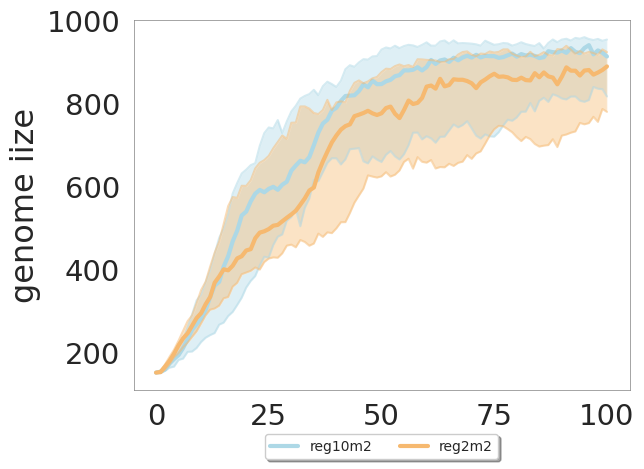

geno_size : 913.64 889.675 0.12597019317097233


<Figure size 640x480 with 0 Axes>

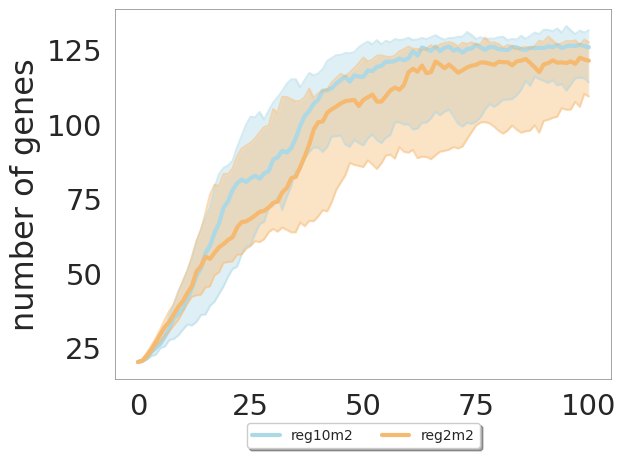

n_genes : 125.78 121.285 0.24882780948800975


<Figure size 640x480 with 0 Axes>

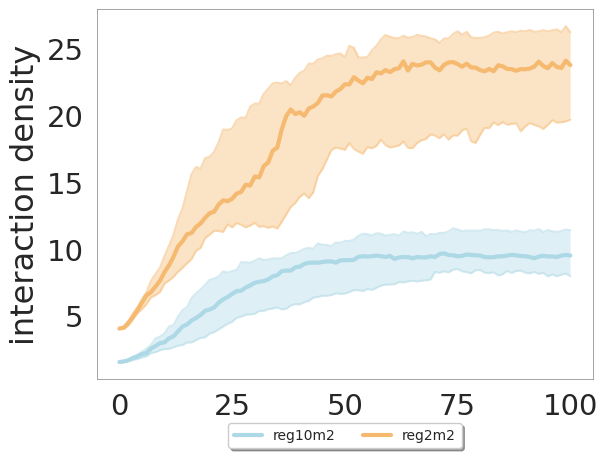

interactions_density : 9.511228235576208 23.73069998923436 1.173735436185757e-09


<Figure size 640x480 with 0 Axes>

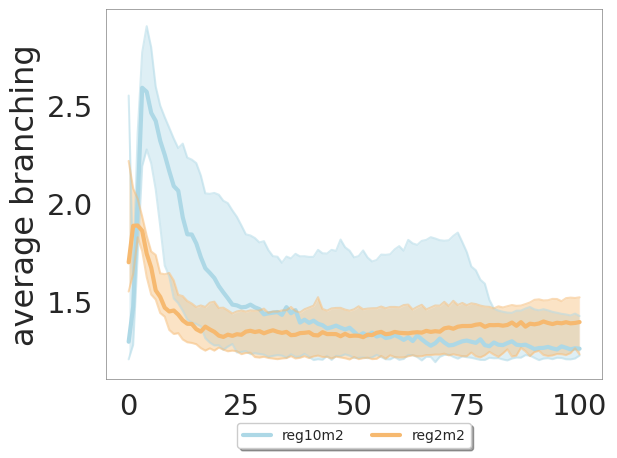

complexity_branch : 1.260595779220778 1.396315175021057 0.49638573117266804


<Figure size 640x480 with 0 Axes>

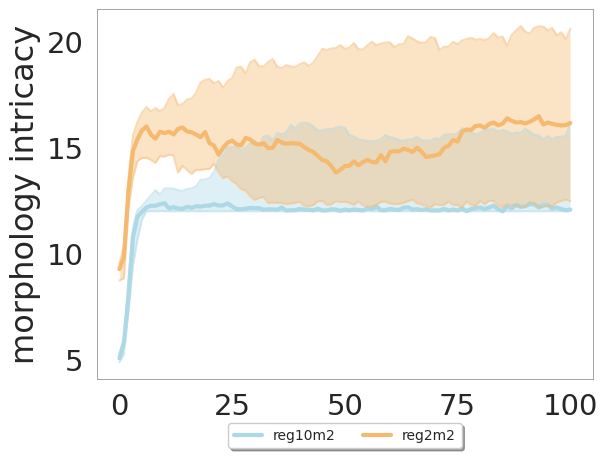

complexity_env : 12.08 16.17 0.025133128401547616


<Figure size 640x480 with 0 Axes>

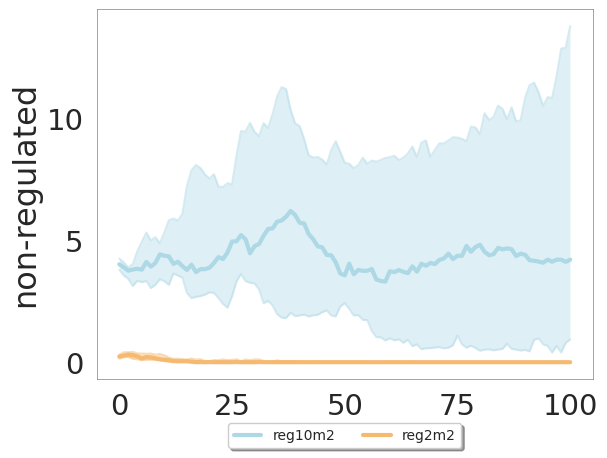

zero_regulators : 4.2 0.0 3.002931123429333e-09


<Figure size 640x480 with 0 Axes>

In [530]:

### COMPLEXITY AND GENO SIZE PROGRESSION

grouped = df_complexity_all.groupby(['experiment_name', 'run', 'gen'])
df_complexity_inner = grouped.agg({
    'geno_size': 'mean',
    'complexity_branch': 'mean',
    'complexity_env': 'mean',
    'n_genes': 'mean',
    'interactions_density': 'mean',
    'zero_regulators': 'mean'
})
df_complexity_inner = df_complexity_inner.reset_index()

q1 = lambda x: x.quantile(0.25)
q3 = lambda x: x.quantile(0.75)

grouped = df_complexity_inner.groupby(['experiment_name', 'gen'])
df_complexity_outer = grouped.agg({
    'geno_size': ['median', q1, q3],
    'complexity_branch': ['median', q1, q3],
    'complexity_env': ['median', q1, q3],
    'n_genes': ['median', q1, q3],
    'interactions_density': ['median', q1, q3],
    'zero_regulators': ['median', q1, q3]
})
df_complexity_outer.columns = [
    ('geno_size', 'median'), ('geno_size', 'Q1'), ('geno_size', 'Q3'),
    ('complexity_branch', 'median'), ('complexity_branch', 'Q1'), ('complexity_branch', 'Q3'),
    ('complexity_env', 'median'), ('complexity_env', 'Q1'), ('complexity_env', 'Q3'),
    ('n_genes', 'median'), ('n_genes', 'Q1'), ('n_genes', 'Q3'),
    ('interactions_density', 'median'), ('interactions_density', 'Q1'), ('interactions_density', 'Q3'),
    ('zero_regulators', 'median'), ('zero_regulators', 'Q1'), ('zero_regulators', 'Q3')
]
df_complexity_outer.columns = ['_'.join(col) for col in df_complexity_outer.columns]
df_complexity_outer = df_complexity_outer.reset_index()

clrs = ['#ADD8E6',
        '#F6B970']
traits_labels = ['genome iize', 'number of genes', 'interaction density', 'average branching', 'morphology intricacy', 'non-regulated']

metrics = ['geno_size', 'n_genes', 'interactions_density', 'complexity_branch', 'complexity_env','zero_regulators']
for idm, metric in enumerate(metrics):

    font = {'font.size': 20}
    plt.rcParams.update(font)
    fig, ax = plt.subplots()#figsize=(3,2))

    plt.xlabel('')
    plt.ylabel(f'{traits_labels[idm]}')
    ax.grid(False)
    ax.spines['top'].set_color('grey')
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_color('grey')
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(0.5)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)


    for idx_experiment, exp in enumerate(experiments):
        metric_exp = df_complexity_outer[df_complexity_outer['experiment_name'] == exp]
        
        ax.plot(metric_exp['gen'], metric_exp[f'{metric}_median'],
                    label=f'{exp}', c=clrs[idx_experiment], linewidth=3)
        
        ax.fill_between(metric_exp['gen'],
                        metric_exp[f'{metric}_Q1'],
                        metric_exp[f'{metric}_Q3'],
                        alpha=0.4, facecolor=clrs[idx_experiment])
        
        ax.plot(metric_exp['gen'],
        metric_exp[f'{metric}_Q1'],
        linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)  # Contour line for Q1

        ax.plot(metric_exp['gen'],
        metric_exp[f'{metric}_Q3'],
        linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)  # Contour line for Q3

        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  fancybox=True, shadow=True, ncol=5, fontsize=10)

    plt.show()
    plt.clf()
    fig.savefig(f'{path}/knockouts/{metric}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

    group1_data = df_complexity_inner[(df_complexity_inner['experiment_name'] == 'reg10m2') & (df_complexity_inner['gen'] == 100) ][f'{metric}']
    group2_data = df_complexity_inner[(df_complexity_inner['experiment_name'] == 'reg2m2') & (df_complexity_inner['gen'] == 100) ][f'{metric}']
    _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    print(metric, ':', group1_data.median(), group2_data.median(), p_value)




 >>>>> disp_y

 >>> n_genes

 -- reg10m2


experiment_name  run  gen  individual_id    disp_y  complexity_env  \
0          reg10m2    8  100           9944  0.885799              12   
1          reg10m2   14  100           9507  1.081522              12   
2          reg10m2   13  100           9869  0.443421              12   
3          reg10m2   23  100           9491  1.152464              12   
4          reg10m2   24  100           9138  1.586727              12   
5          reg10m2   26  100           9675  1.060793              12   
6          reg10m2   11  100           9851  0.633508              12   
7          reg10m2   25  100           8170  0.985403              12   
8          reg10m2   15  100           7338  1.694608              12   
9          reg10m2   21  100           9169  1.117171              20   
10         reg10m2    1  100           9776  2.182697              12   
11         reg10m2   10  100           9142  1.159900              32   
12         reg10m2   18  100           9435  1.376785              26   
13         reg10m2   27  100           9395  1.540519              12   
14         reg10m2    4  100           9807  1.875566              12   
15         reg10m2    9  100           9314  2.705512              12   
16         reg10m2    6  100           9410  1.932541               4   
17         reg10m2    7  100           8171  1.655679              22   
18         reg10m2    3  100          10006  1.420073              12   
19         reg10m2   28  100           9235  1.427837              14   
20         reg10m2   12  100           8948  1.993563              26   
21         reg10m2   17  100           9814  1.630034              12   
22         reg10m2   22  100           9961  2.356366              28   
23         reg10m2   16  100           9746  2.066838               4   
24         reg10m2   29  100           9519  2.489173              22   
25         reg10m2    5  100           9733  1.090487              12   
26         reg10m2   19  100           9027  0.740083              20   
27         reg10m2   20  100           9850  1.855915              20   
28         reg10m2   30  100           9635  1.609380              12   
29         reg10m2    2  100           8710  3.070760              12   

    complexity_branch  complexity_net  zero_regulators_x  geno_size  n_genes  \
0            1.333333               9                 25        226       32   
1            1.187500              97                 12        315       43   
2            2.500000             288                 21        316       45   
3            1.187500             279                  2        408       57   
4            1.187500             427                  0        588       82   
5            1.187500             957                  0        606       84   
6            1.187500             465                 13        660       88   
7            1.272727            1426                 10        738      102   
8            1.187500            1067                  0        761      104   
9            1.461538             770                 22        759      108   
10           1.250000             800                  7        837      116   
11           1.900000            1280                  4        889      121   
12           1.900000            1151                  0        891      123   
13           1.187500            1275                  0       1000      131   
14           1.187500             982                 19       1000      131   
15           1.230769            1256                  8       1000      134   
16           1.000000            2567                  7       1001      136   
17           1.357143            1548                  0       1001      136   
18           1.187500            1566                  0       1001      136   
19           1.357143            1453                  6       1000      137   
20           1.727273            1635                  4   

Average of 'b' in the first : 1.2517921540305315
Average of 'b' in the second : 1.8696160504827266
  p-value: 0.0062


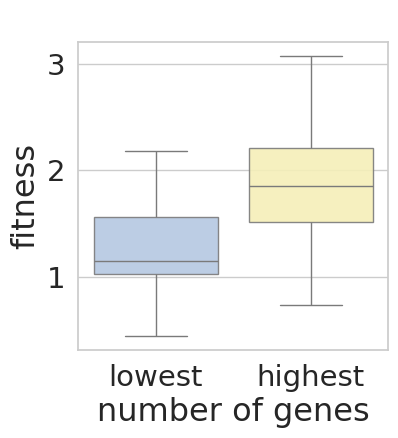


 -- reg2m2


experiment_name  run  gen  individual_id    disp_y  complexity_env  \
0           reg2m2   22  100           9757  1.933192               4   
1           reg2m2   13  100           7605  2.416982              12   
2           reg2m2   14  100           9995  3.543763              12   
3           reg2m2   19  100           5654  2.080221              12   
4           reg2m2   28  100           9932  2.169958              20   
5           reg2m2    3  100           2207  1.614839              22   
6           reg2m2    6  100           9236  2.752592              12   
7           reg2m2    9  100           3998  1.997138              24   
8           reg2m2    5  100           9535  2.177725              12   
9           reg2m2    7  100           9733  1.698635              20   
10          reg2m2   24  100           9976  1.791301              12   
11          reg2m2   29  100           9435  1.715356              16   
12          reg2m2   10  100           8083  1.835857              20   
13          reg2m2    8  100           8030  2.390023              20   
14          reg2m2    1  100           8884  1.684574               6   
15          reg2m2   12  100           9169  1.826460              12   
16          reg2m2   11  100           7659  2.017231              22   
17          reg2m2   18  100           9764  2.396047              16   
18          reg2m2   15  100           9914  2.509492              14   
19          reg2m2   30  100           9797  1.818211              12   
20          reg2m2   16  100           8247  2.275518              20   
21          reg2m2   23  100           8316  2.379379              24   
22          reg2m2   26  100           9296  1.235414              16   
23          reg2m2   17  100           9696  1.669452              20   
24          reg2m2   20  100           8721  2.682978              22   
25          reg2m2   27  100           8924  2.187271              16   
26          reg2m2   25  100           9625  1.924577              16   
27          reg2m2    2  100           9287  2.420471              12   
28          reg2m2   21  100           9982  2.999503              24   
29          reg2m2    4  100           9202  2.092012              20   

    complexity_branch  complexity_net  zero_regulators_x  geno_size  n_genes  \
0            1.000000             246                  0        264       35   
1            1.428571             355                  0        302       41   
2            1.187500             106                  7        295       42   
3            1.333333             494                  0        340       47   
4            1.357143             541                  0        374       53   
5            1.583333             930                  0        503       69   
6            1.600000             892                  0        499       69   
7            1.583333             971                  0        521       71   
8            1.187500            1676                  0        633       87   
9            1.727273            1839                  0        680       94   
10           1.333333            1823                  0        688       95   
11           1.266667            1908                  0        723      100   
12           1.727273            2379                  0        743      104   
13           2.375000            2306                  0        780      109   
14           1.055556            2529                  0        806      113   
15           1.187500            2346                  0        846      117   
16           1.357143            3013                  0        888      122   
17           1.266667            3347                  0        895      124   
18           1.461538            3209                  0       1000      135   
19           1.333333            7661                  7       1000      135   
20           1.357143            3668                  0   

Average of 'b' in the first : 2.1201436329943424
Average of 'b' in the second : 2.162267770400892
  p-value: 0.4306


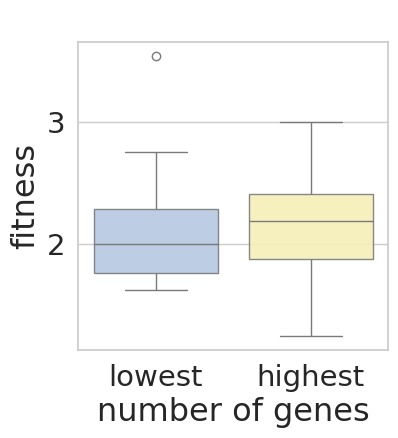

In [17]:

### FIT VS GENOSIZE 


metrics_dist = ['disp_y']
metrics_order = ['n_genes']

for metric_dist in metrics_dist:
    print('\n >>>>>',metric_dist)
    for metric_order in metrics_order:
        print('\n >>>',metric_order)
        for exp in experiments:
            print('\n --',exp)
            df_comp_g = corr_df_all[ (corr_df_all['experiment_name'] == exp) ] 
            df_comp_g = df_comp_g[ (df_comp_g['ranking'] == 'best') ] 
            df_sorted = df_comp_g.sort_values(by=metric_order).reset_index(drop=True)
     
            midpoint = len(df_sorted) // 2
            first_half = df_sorted.iloc[:midpoint]
            second_half = df_sorted.iloc[midpoint:]
            
            # Calculate and display the averages for 'b' in each half
            avg_first_half = first_half[metric_dist].mean()
            avg_second_half = second_half[metric_dist].mean()
    
            print(f"Average of 'b' in the first : {avg_first_half}")
            print(f"Average of 'b' in the second : {avg_second_half}")

            _, p_value = mannwhitneyu(first_half[metric_dist], second_half[metric_dist], alternative='two-sided')
            print(f"  p-value: {round(p_value, 4)}")
            
            # Add a new column to each half to indicate "First Half" or "Second Half"
            first_half['half'] = 'lowest'
            second_half['half'] = 'highest'
            
            #  Concatenate the two halves back into a single DataFrame
            df_concat = pd.concat([first_half, second_half], ignore_index=True)
            
            # Plot variable 'disp_y' for each half using box plots
            plt.figure(figsize=(4, 4))
            bp = sb.boxplot(x='half', y=metric_dist, data=df_concat,palette=["#aec7e8", "#fff7ae"], boxprops=dict(alpha=0.9) )

            plt.xlabel("number of genes")
            plt.ylabel("fitness")
            plt.title(' ')
            plt.savefig(f'{path}/knockouts/geno_fit_{exp}.png', dpi=300, bbox_inches='tight')
            plt.show() 


